## TODO:
    1. Update EIC to use excel sheet - add areas, p values, original RTs, etc.
    
Moving from making pngs of each of the EICs to using Joe's Excel sheet maker for easier visualization and less file clutter

In [1]:
from Utils import Methods
import os
import platform
from datetime import *
import sys
import warnings
import psutil
import traceback
import csv
import math
import shutil 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import qsturng, psturng
import numpy as np
import numpy_indexed as npi
import pandas as pd
from pyopenms import *
from datetime import *
import pandas as pd
import pingouin as pg
from hypothetical.descriptive import var
from scipy import stats, signal
from scipy.stats import zscore, t
from scipy.optimize import curve_fit
from scipy.integrate import quad, cumulative_trapezoid
from scipy.signal import find_peaks, peak_widths, welch, savgol_filter
from scipy.ndimage import gaussian_filter1d
import scikit_posthocs as sp
from itertools import combinations
import peakutils
import importlib

/home/gridsan/mlee/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Inputs

In [4]:
prots = ['Aliq1','Aliq2']   # List of proteins in selection
prots.sort()                                             # Alphabetizes all of the proteins for ease
selection = '329-077 X12K Targeted Test Updated'       
# Name of selection, will be in folder name                                                             # E = Eclipse, L= Lumos, UT = Untargeted, T = Targeted
enr_score_cutoff = 1/len(prots)                                                     # cutoff score for sequencing run
p_score_cutoff = 0.10
show_EICs = False
nr_EICs = 100
peak_RT = 300                                 # width (in seconds) of peak, used for max intensity search, gets divided by 2 for +-
peps_sec = 3                    # maximum amount of peptides that can coelute, for building inclusion list
n_reps = 3
lib_size = 15
conc_lib_start = 10    # pM/member
PRTC_conc = 2*1000     # pM/member
    
TIME = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")                   # Gets current time to prevent duplicate folders        
parent_dir = os.path.join('/home','gridsan','mlee','ASMS_Analysis','20221129-329-077_X12K_2500_Members_Targeted_Seq_Test')
folder = selection + ' ' + TIME                                        # Name of new folder to save output
data_dir = os.path.join(parent_dir,folder)                               # New folder to store centroided data
save_dir = os.path.join(parent_dir,folder)                               # If data is already centroided, use this folder 
                                                                         #    to save useful output
default_thresh = 5E4                                                     # Threshold of peak detection (ion counts)
area_limit = 1E5
min_escore_quality = 0.6
gradient_time = 120
peps_min = 10
LOD = 1.5e4                                                              # Number of replicates per protein
centroided = False                                                       # Will skip the centroiding step if True
check_data = True                                                        # Will skip the TIC and 2D plotting if False, prints out TIC otherwise
full_out = True                                                          # Will print all features found for each protein
known_binders = False                                                    # Do you have a formatted csv of known binders to find (for diagnostics)
PRTC_check = True

do_second_filter = True
do_EICs = True                                                           # True to activate EICs, take majority of runtime
do_subtract = False                                                      # Will subtract background from intensity for scoring
use_savgol = True
use_fft = False

## Directory and reference setup

In [5]:
Methods.sys_checks(parent_dir,prots,centroided,enr_score_cutoff,p_score_cutoff,peak_RT,peps_sec,n_reps,nr_EICs,LOD,True)
eic_dirs,eic_dirs_spec,eic_dirs_nonspec,eic_dirs_other,png_dir,PRTC_dir = Methods.directory_setup(parent_dir,folder,save_dir,prots,centroided)

if PRTC_check:
    PRTC_masses = [900.5524,985.5220,1114.6374,1171.5861,1224.619,1488.7704]
    PRTC_rts = [8.7*60,6.5*60,13.6*60,11.3*60,7.5*60,13.7*60]
    PRTC_mass_round = np.round(PRTC_masses,2)

RAW files found to analyze: []
Error in inputs! Please check your entries


/home/gridsan/mlee/pyBinder/Utils/Methods.py:55: UserWarning: RAW files for Aliq1 not found in data directory
  warnings.warn(f'RAW files for {prot} not found in data directory')
/home/gridsan/mlee/pyBinder/Utils/Methods.py:55: UserWarning: RAW files for Aliq2 not found in data directory
  warnings.warn(f'RAW files for {prot} not found in data directory')


## Data centroiding and checks

In [6]:
data_dir = Methods.data_centroiding(centroided,parent_dir,folder,PRTC_dir,data_dir)

329-077_X12K_2500MemAliq1_1.mzML loaded
peaks picked
another one done
1
329-077_X12K_2500MemAliq1_2.mzML loaded
peaks picked
another one done
2
329-077_X12K_2500MemAliq1_3.mzML loaded
peaks picked
another one done
3
329-077_X12K_2500MemAliq2_1.mzML loaded
peaks picked
another one done
4
329-077_X12K_2500MemAliq2_2.mzML loaded
peaks picked
another one done
5
329-077_X12K_2500MemAliq2_3.mzML loaded
peaks picked
another one done
6


loaded
Fifth percentile = 22021959.0


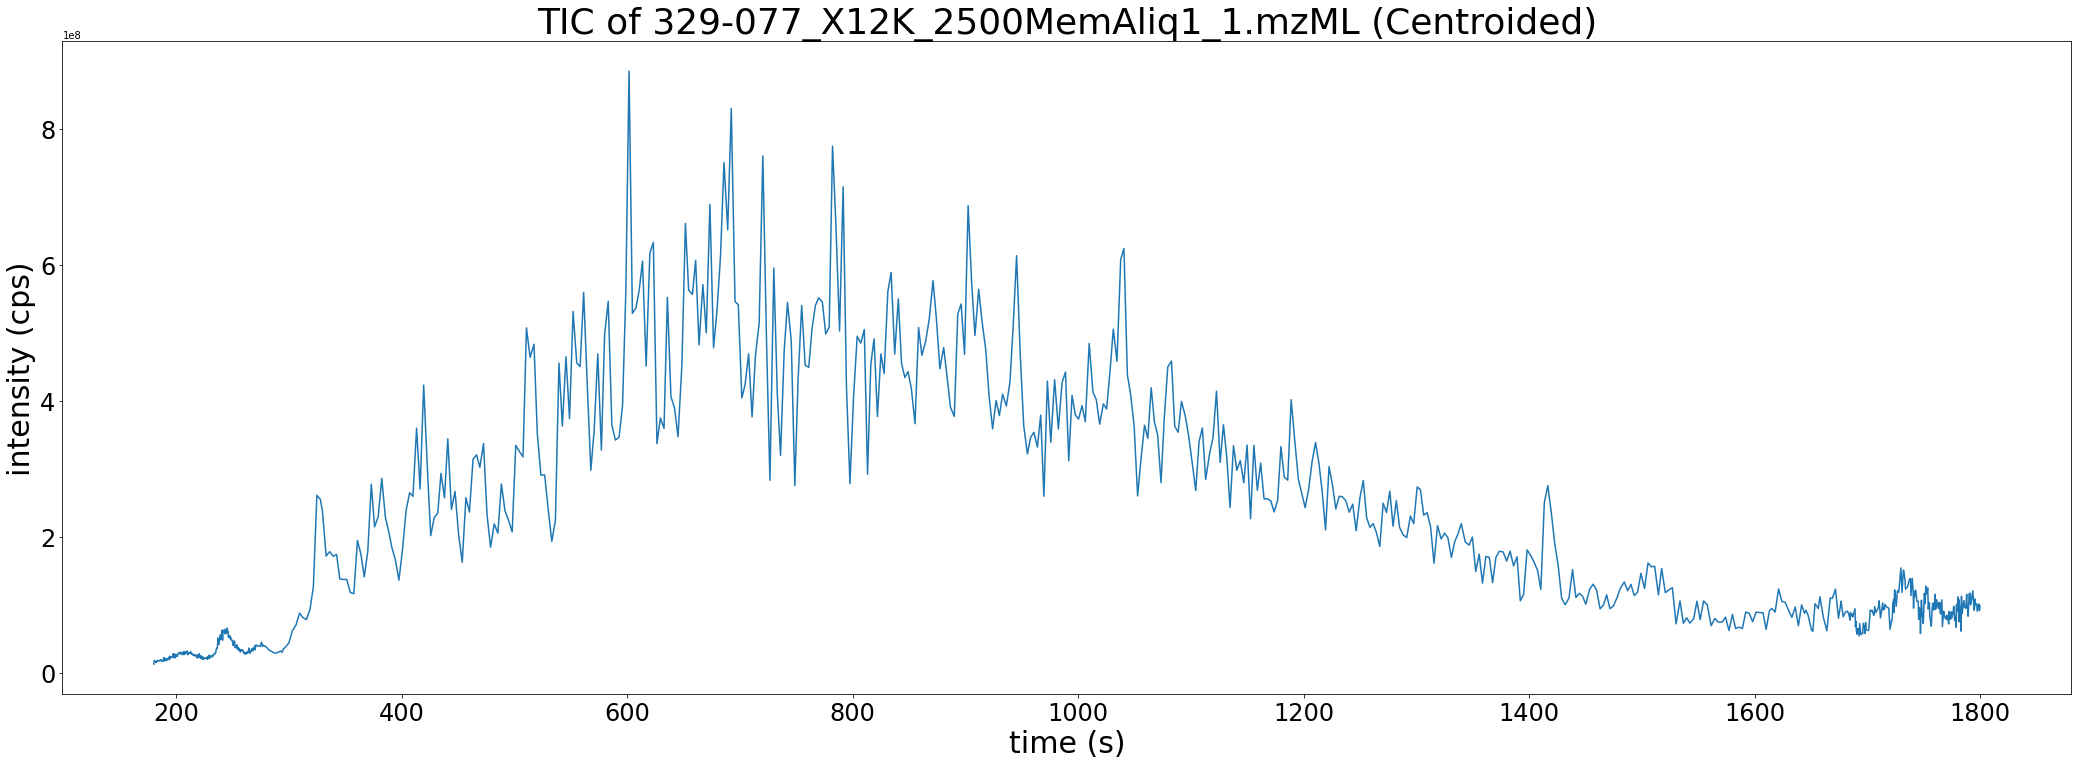

loaded
Fifth percentile = 8722270.5


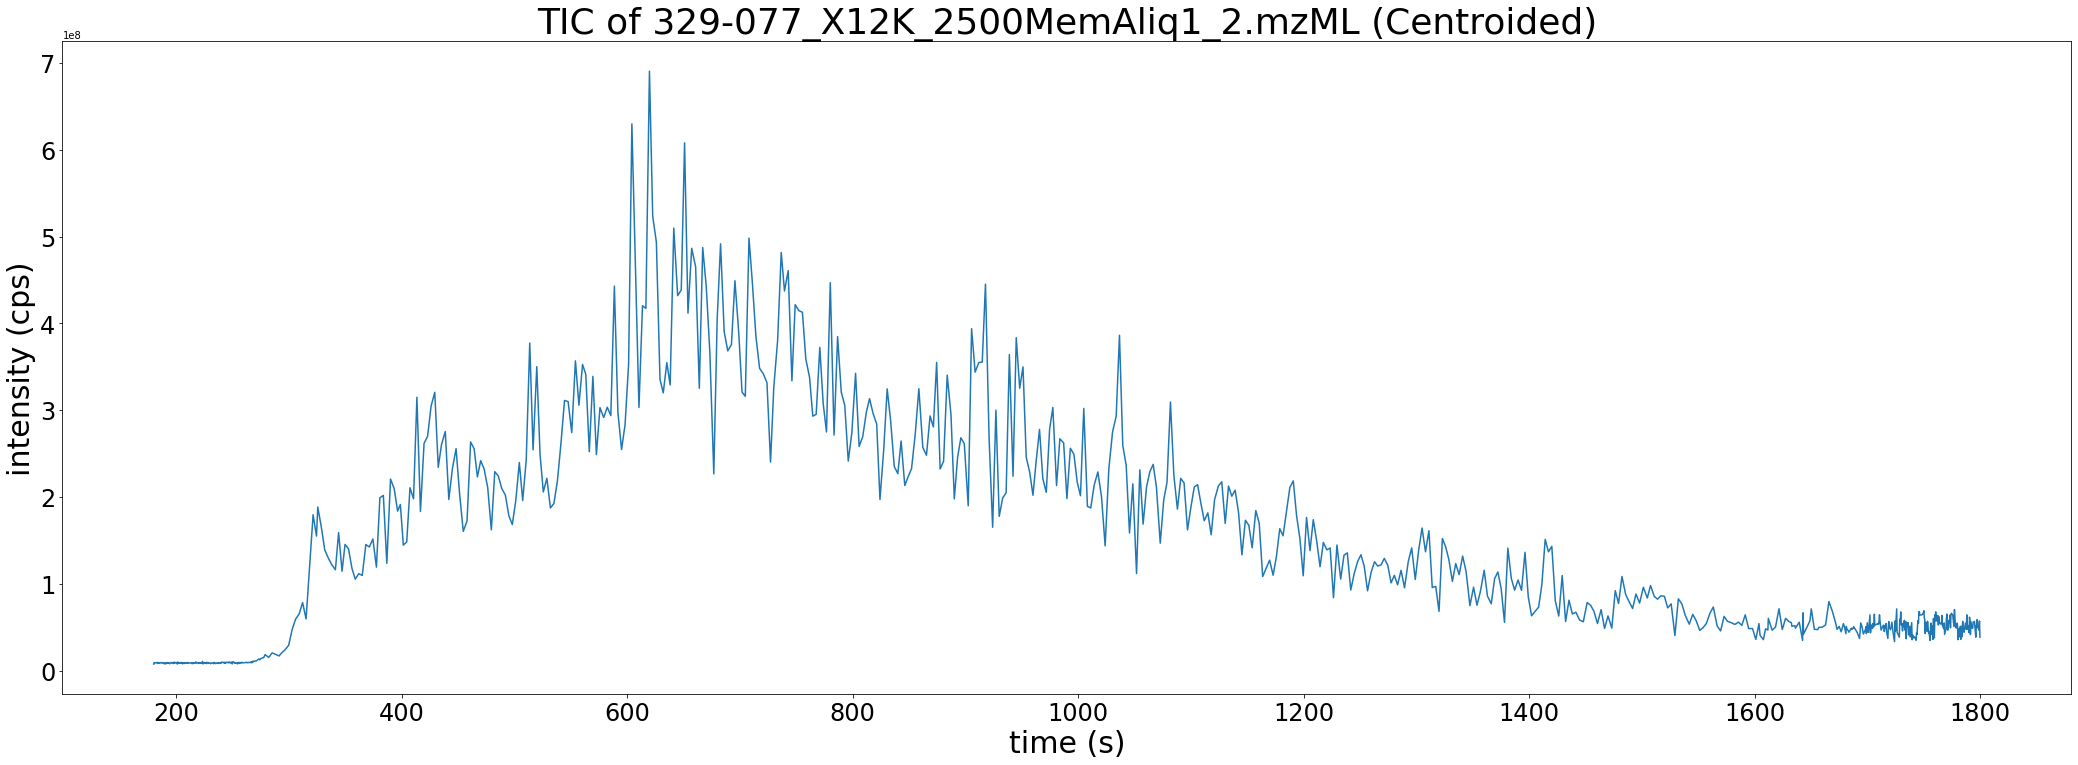

loaded
Fifth percentile = 8733208.0


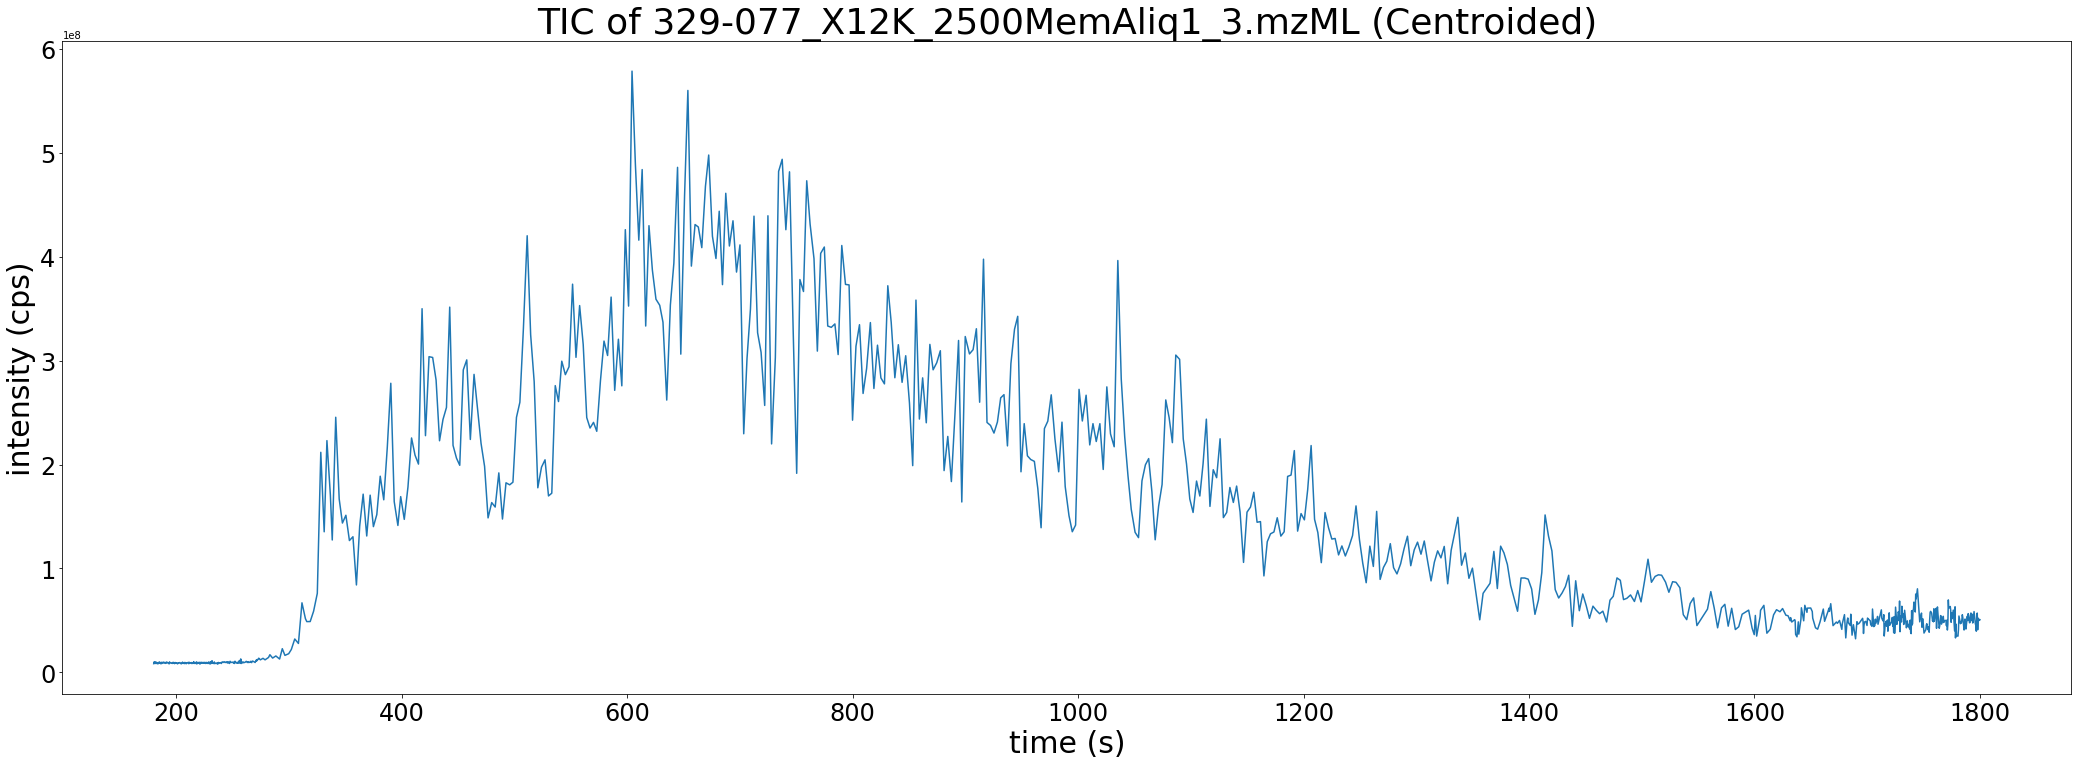

loaded
Fifth percentile = 8824805.65


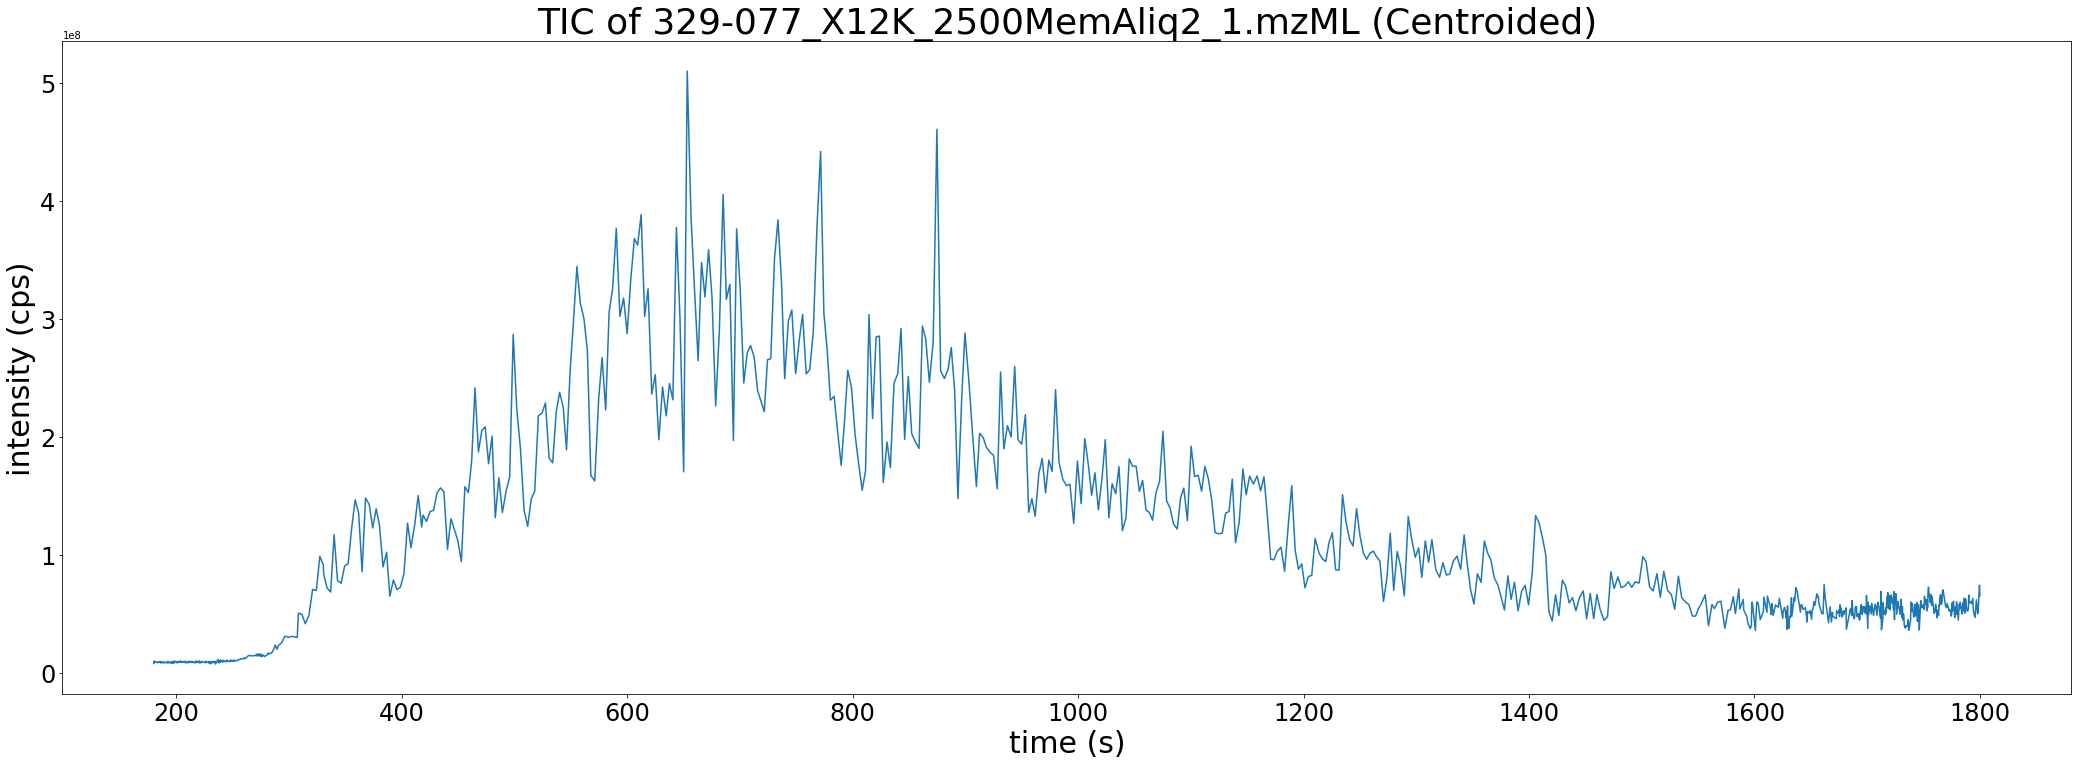

loaded
Fifth percentile = 9099377.8


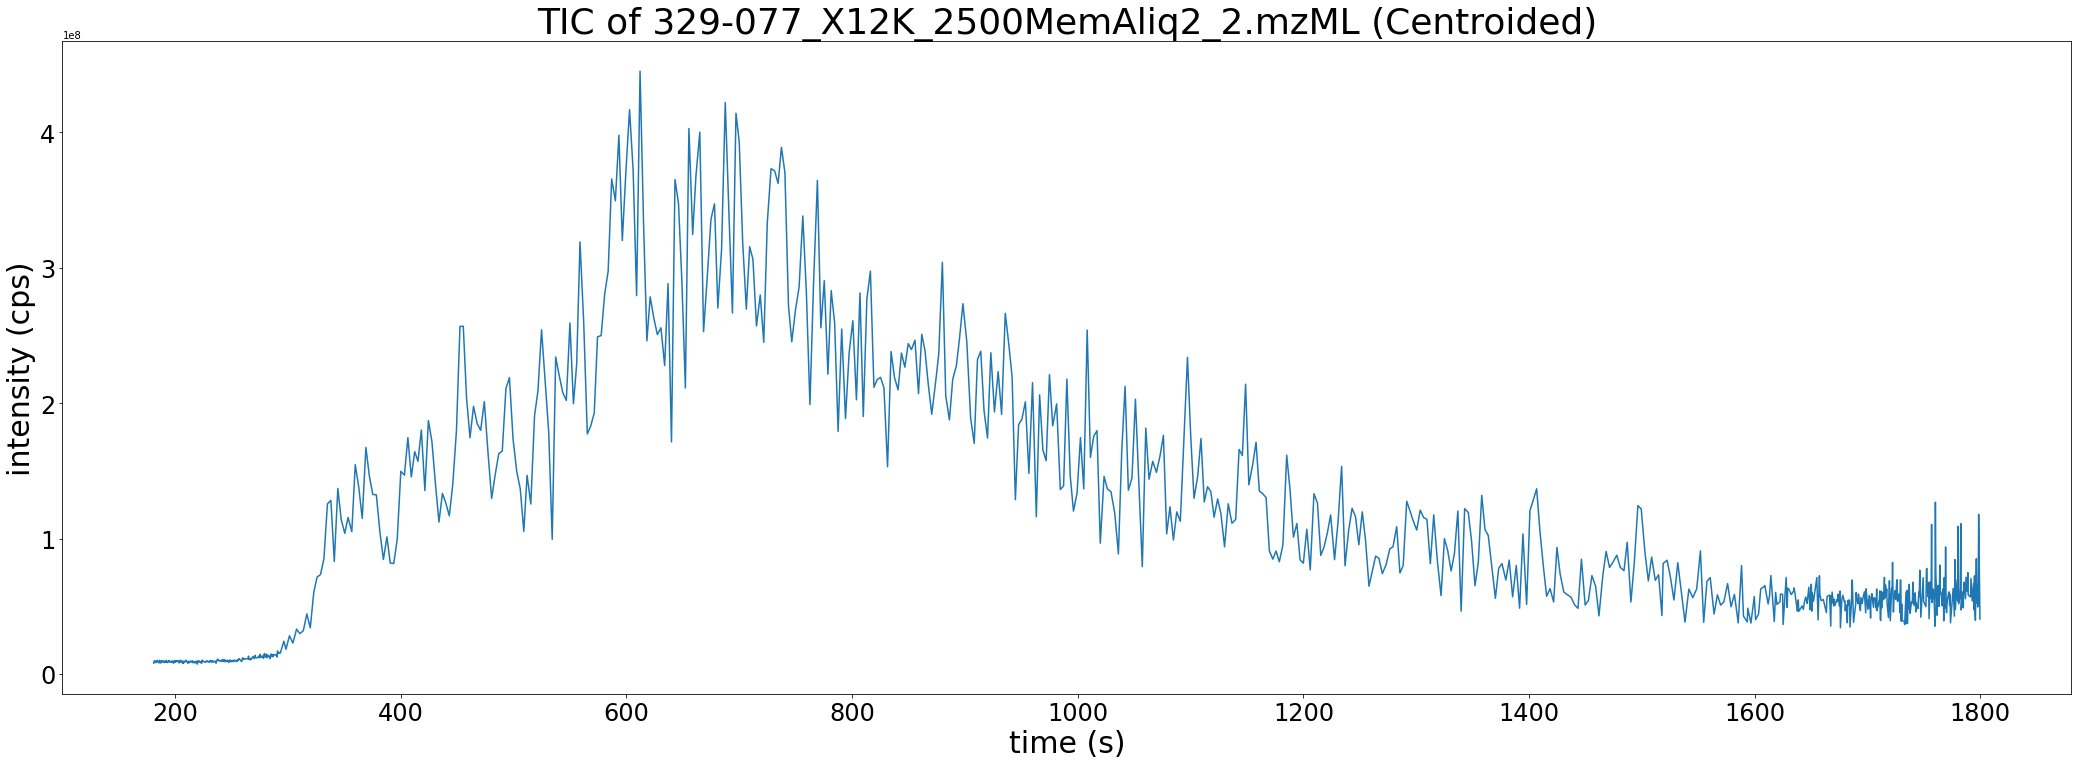

loaded
Fifth percentile = 9403389.0


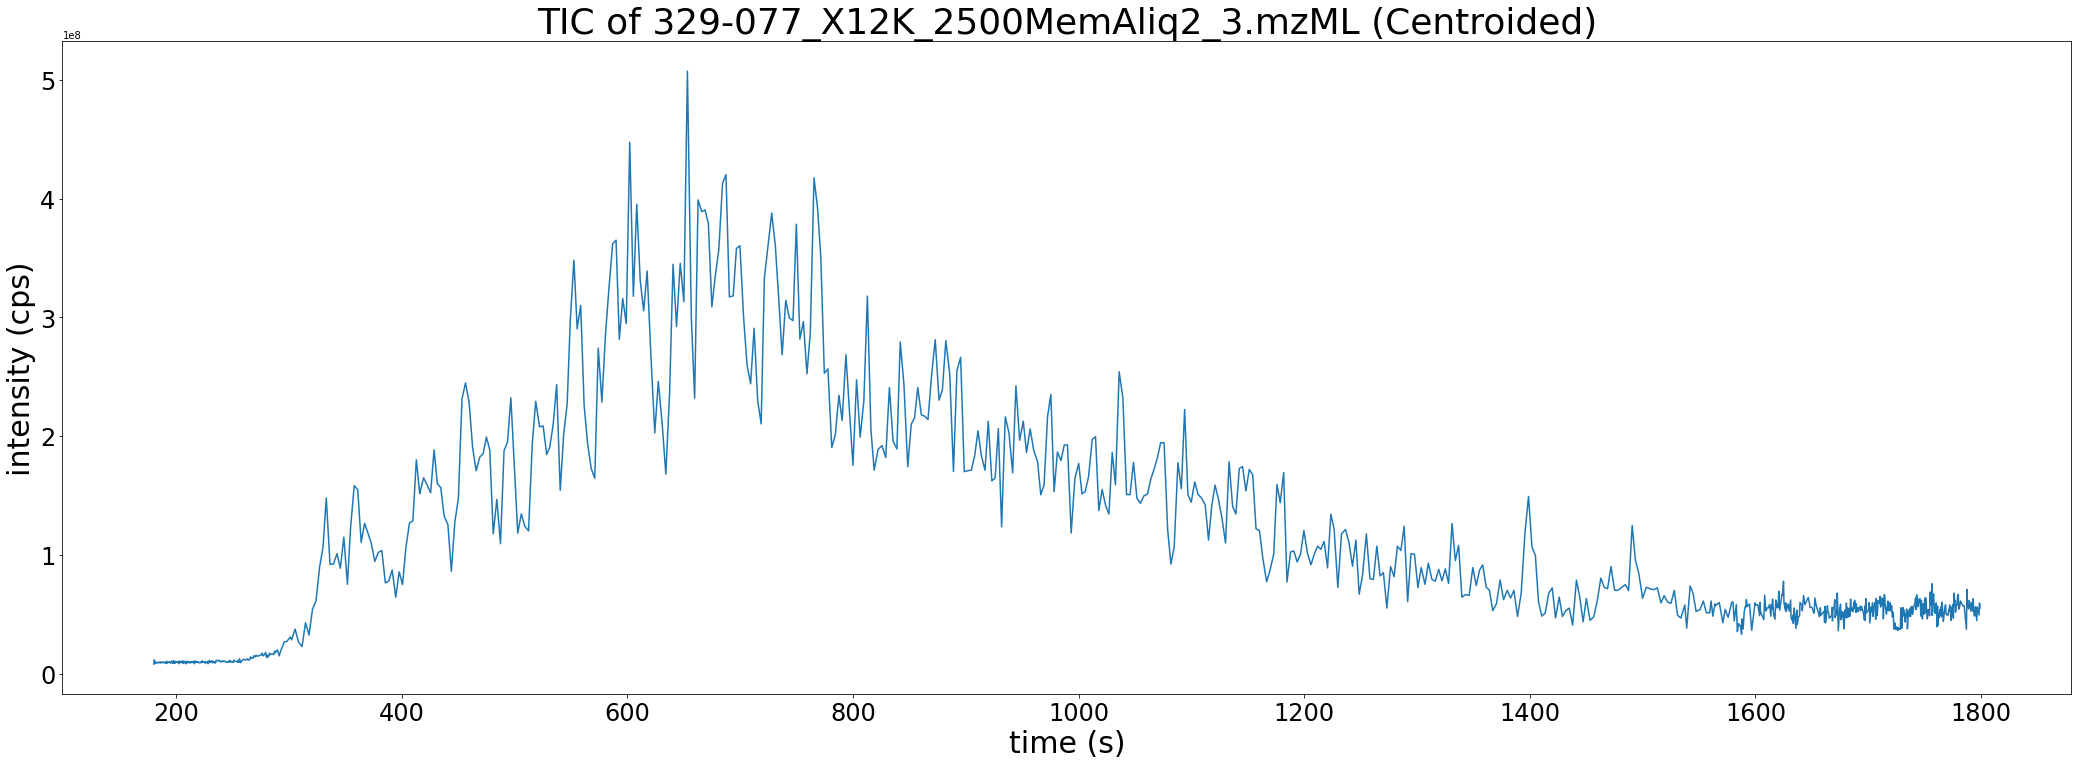

loaded
Fifth percentile = 22021959.0


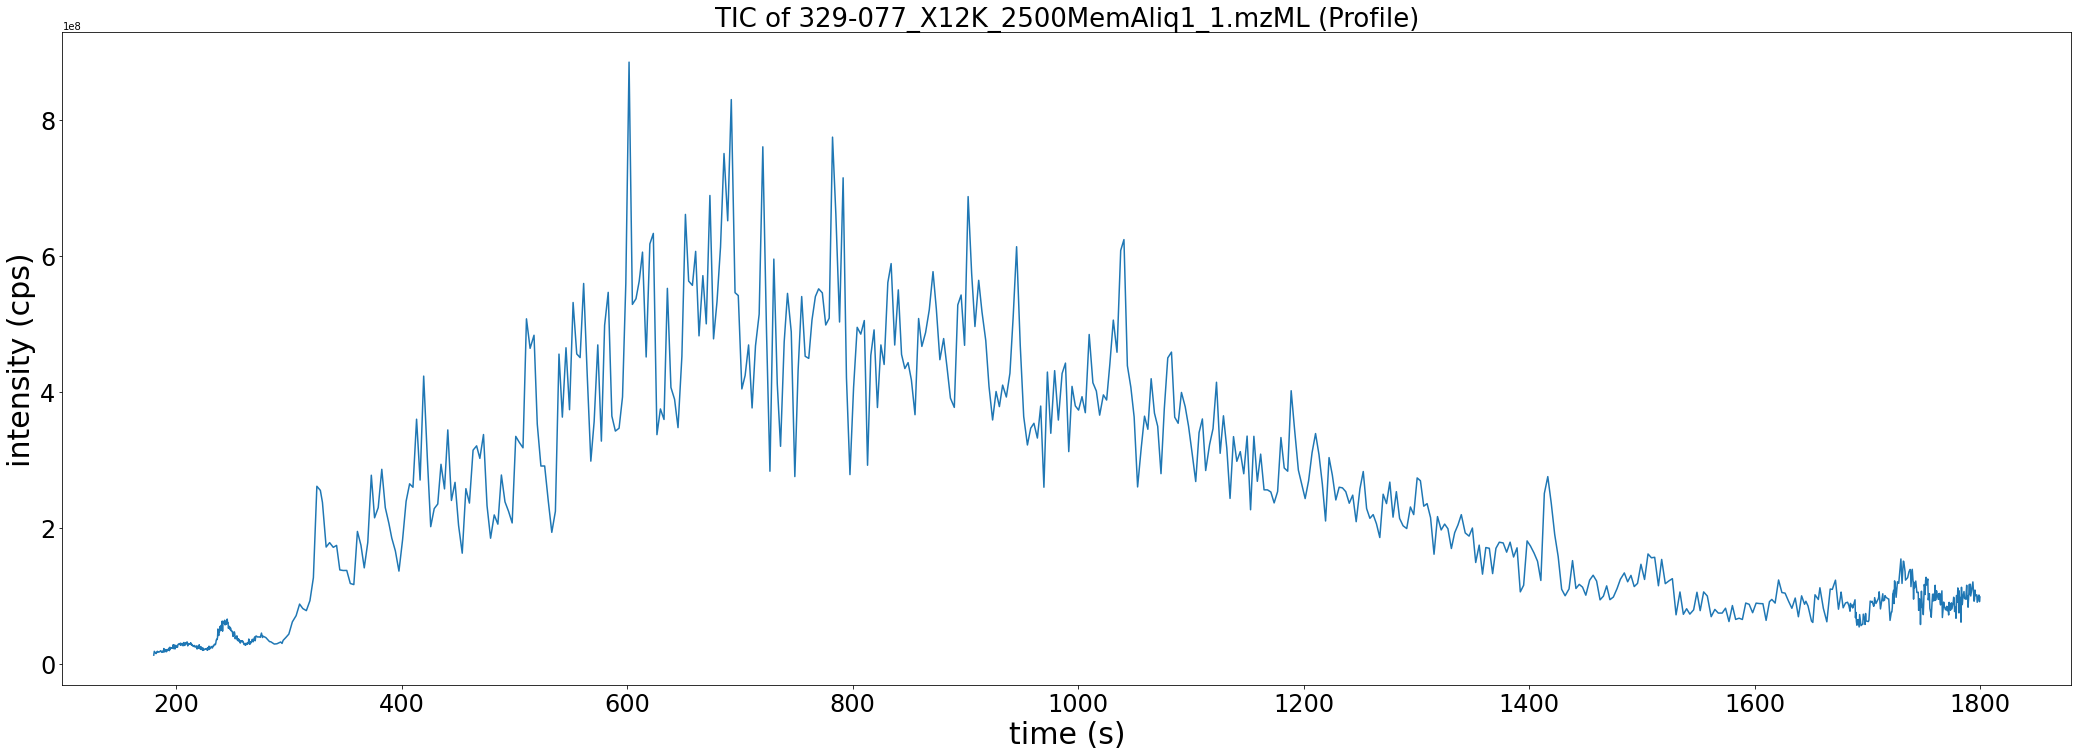

loaded
Fifth percentile = 8722270.5


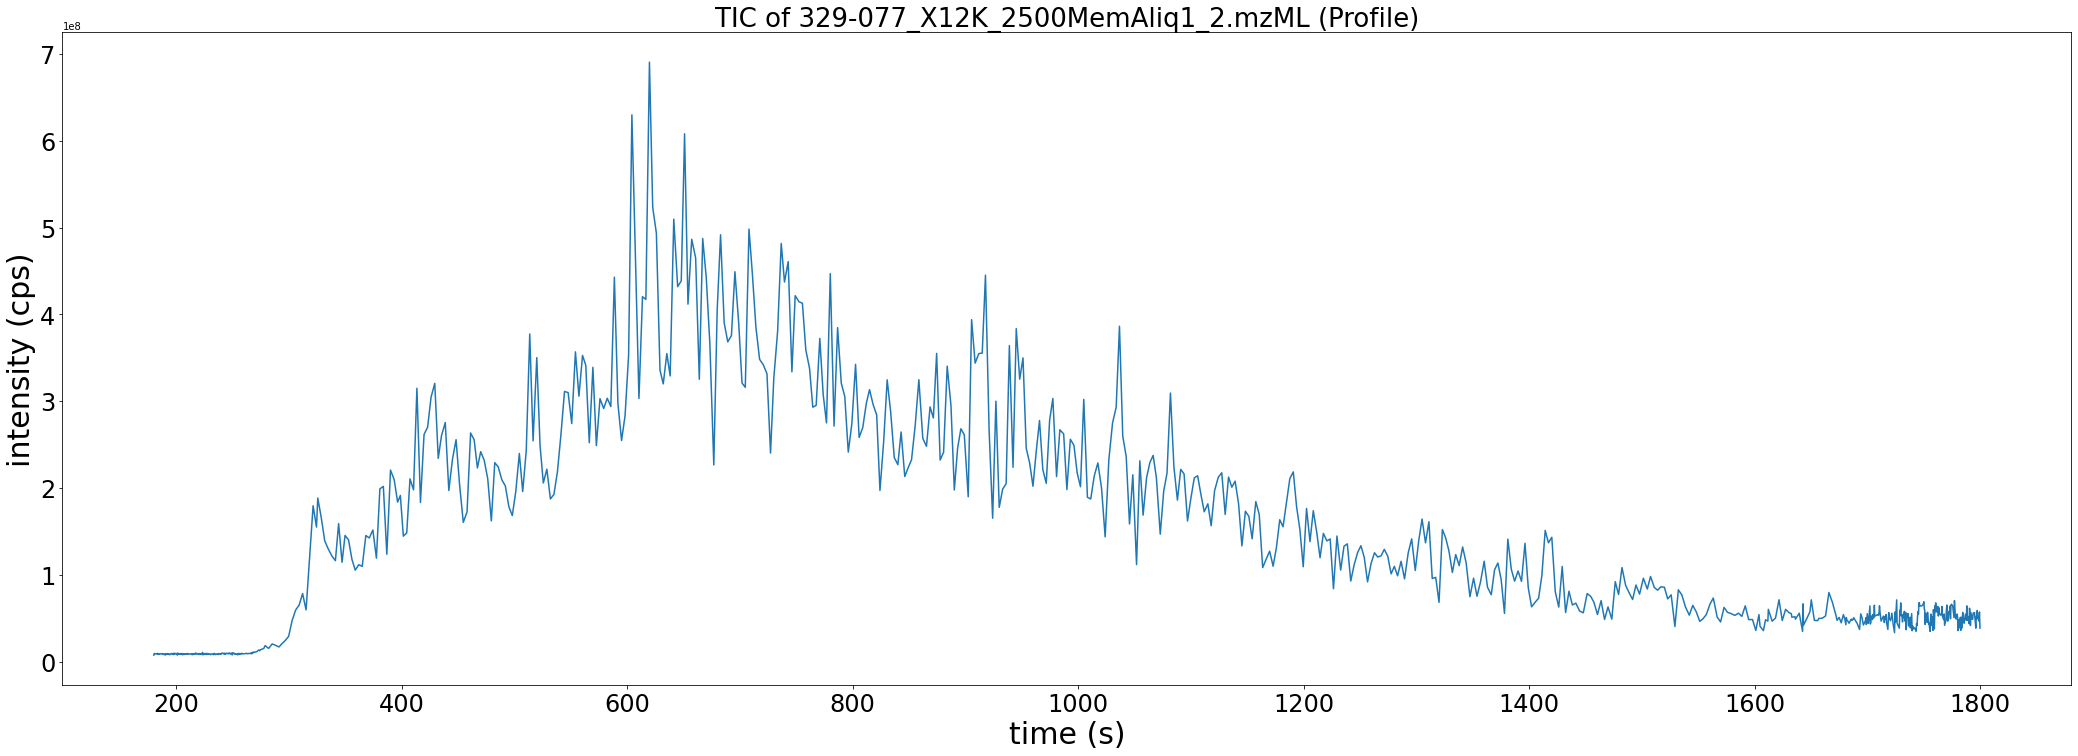

loaded
Fifth percentile = 8733208.0


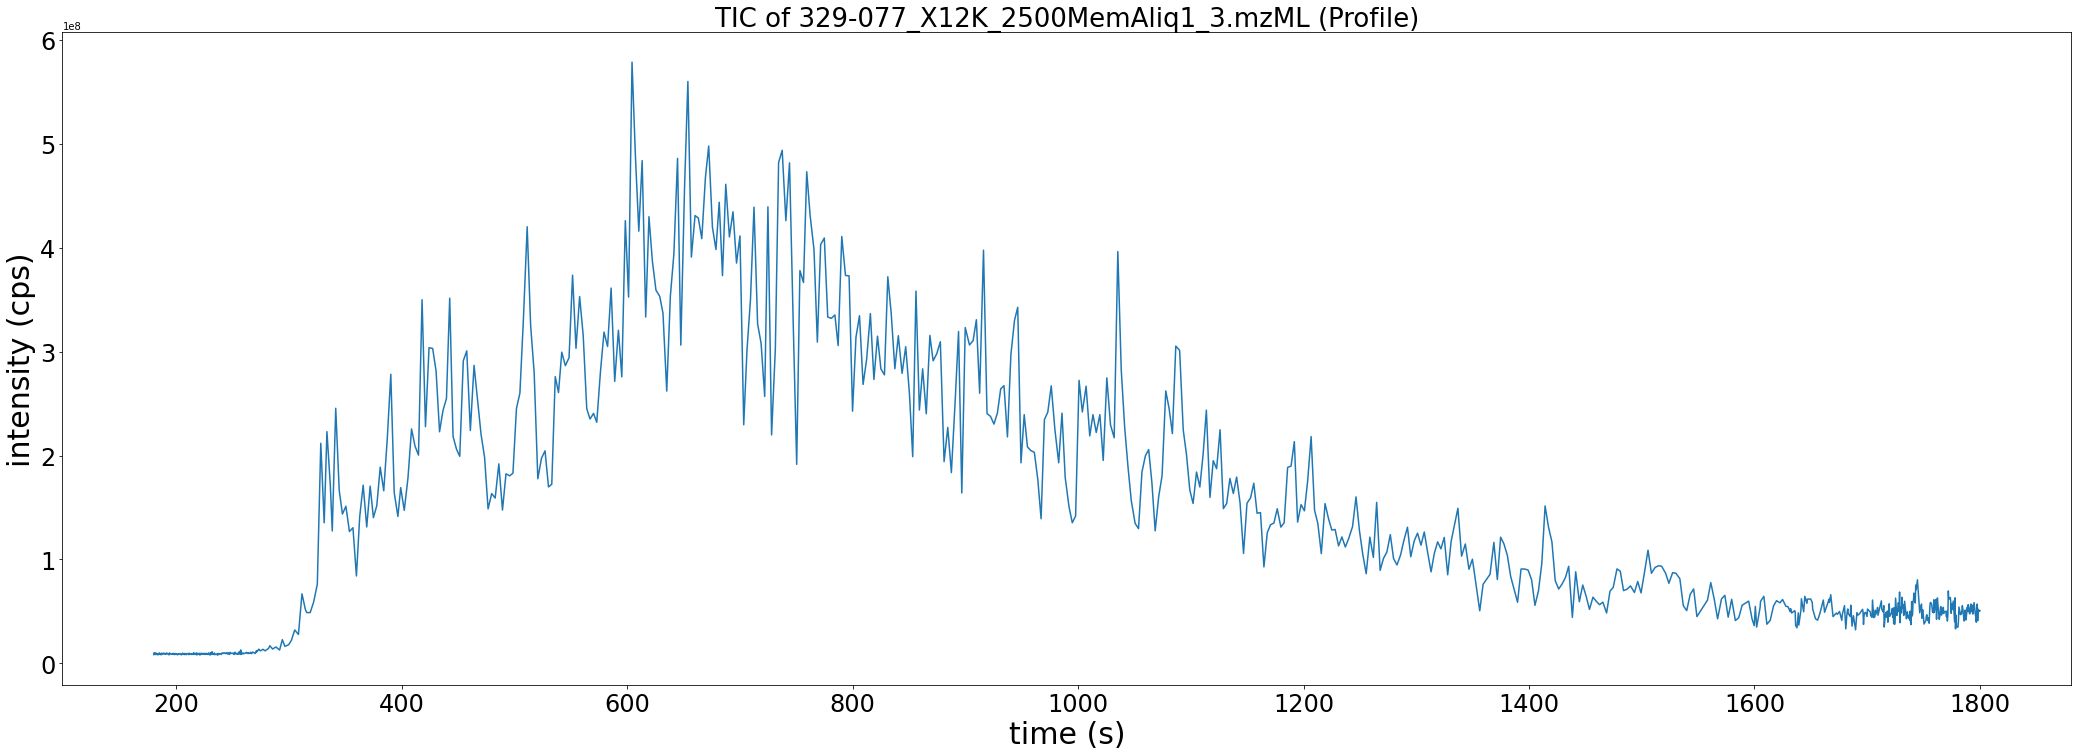

loaded
Fifth percentile = 8824805.65


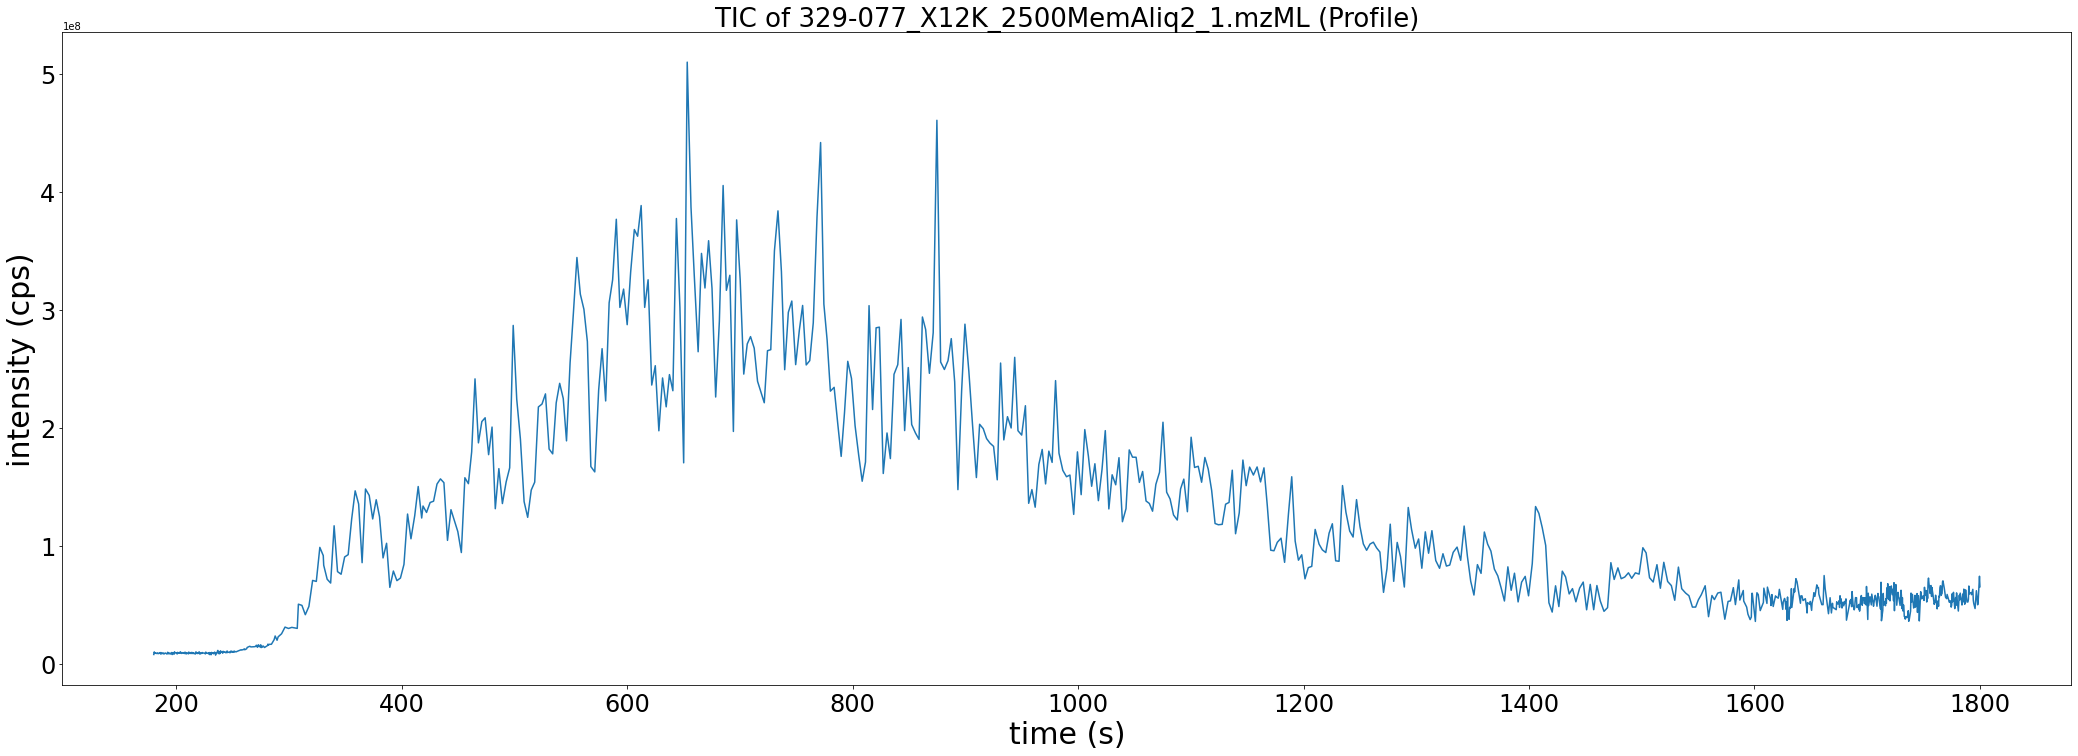

loaded
Fifth percentile = 9099377.8


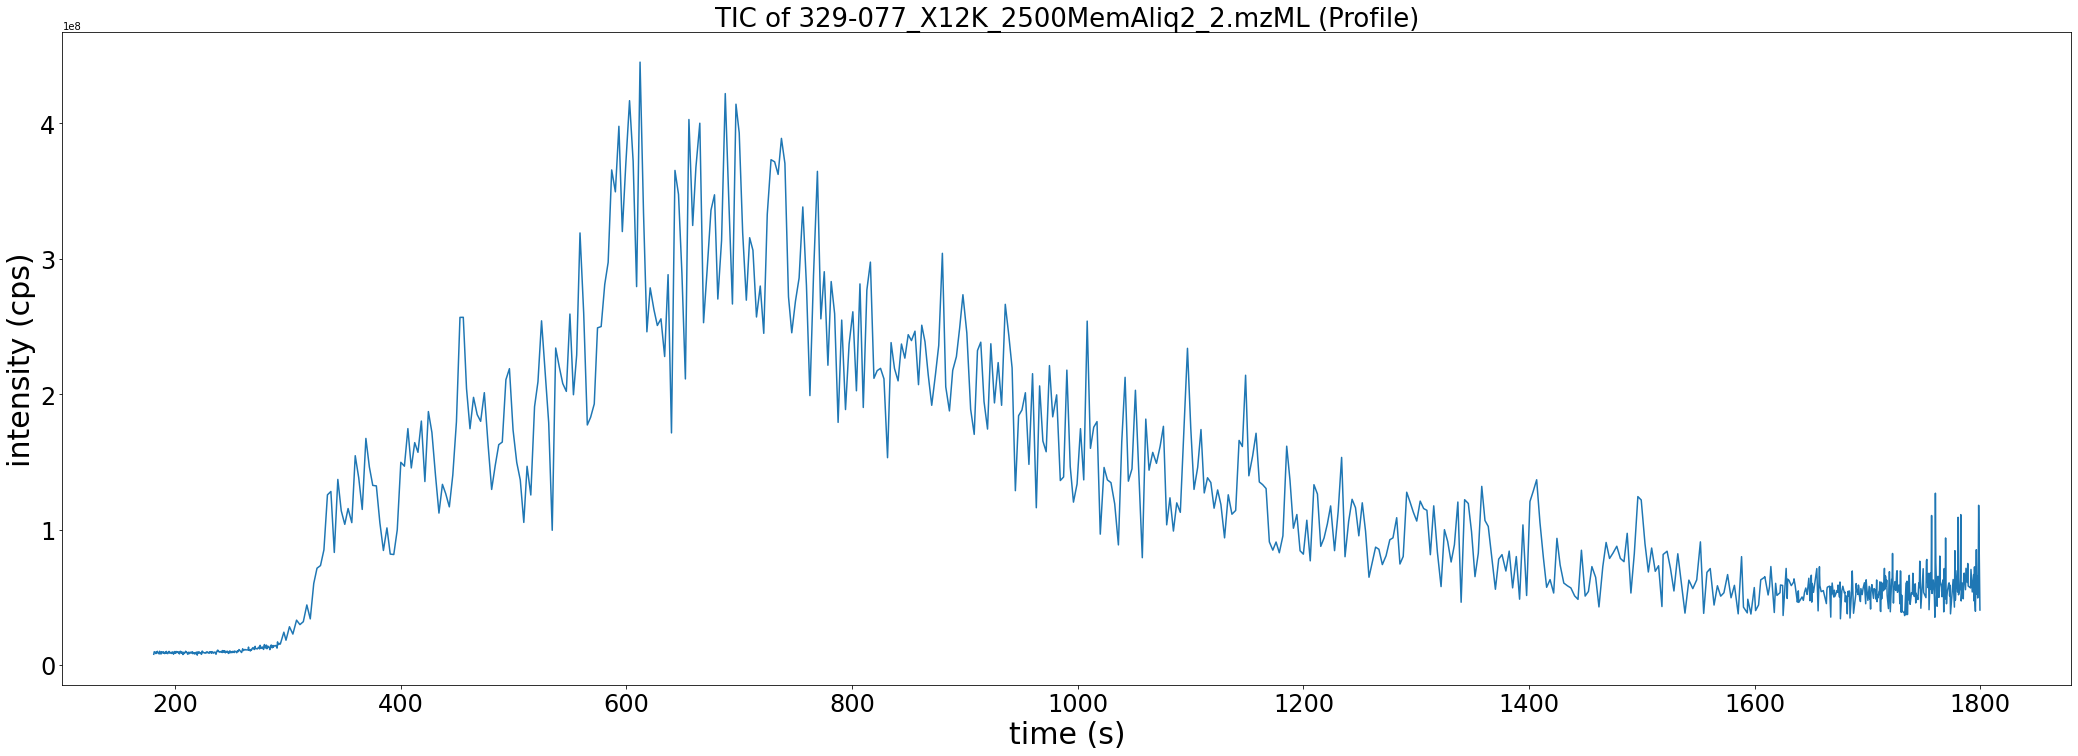

loaded
Fifth percentile = 9403389.0


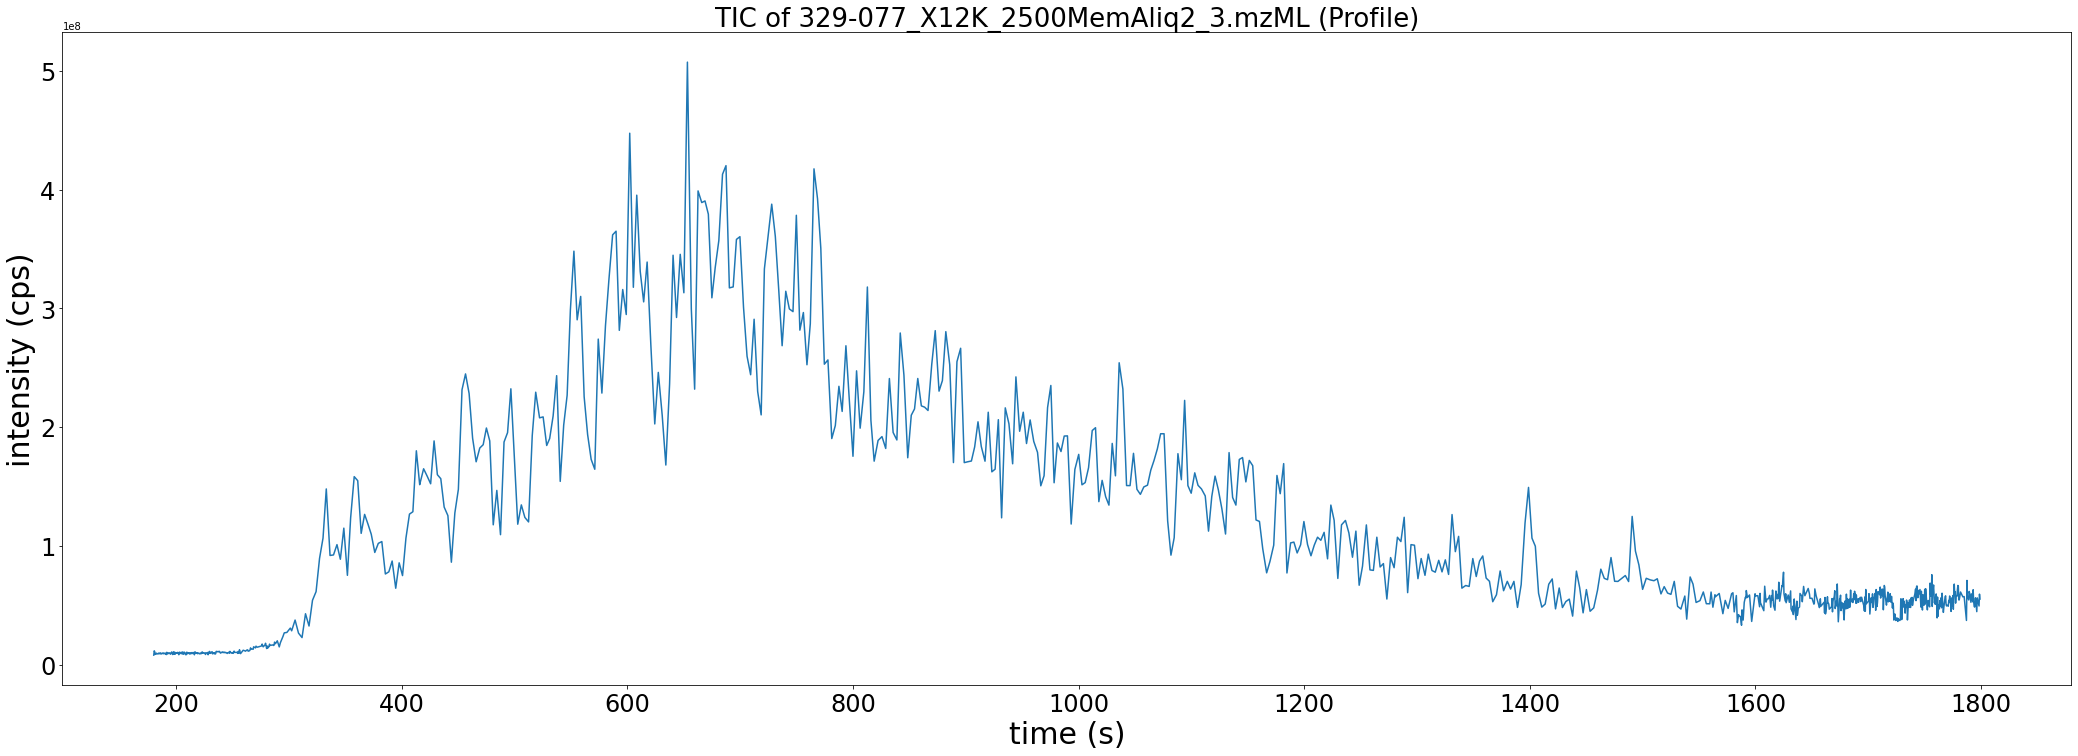

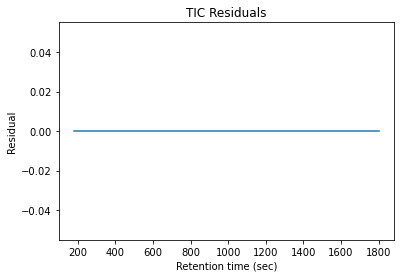

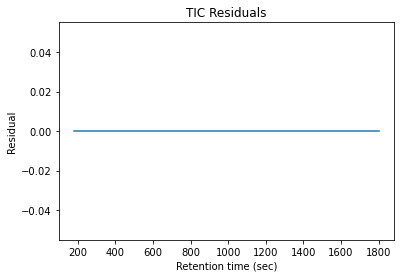

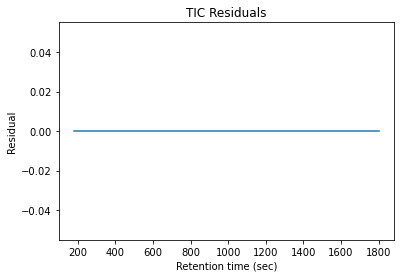

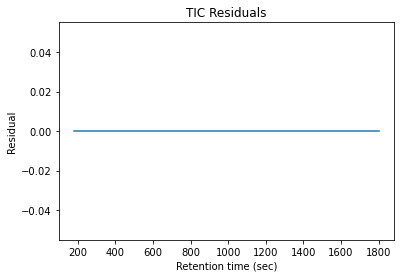

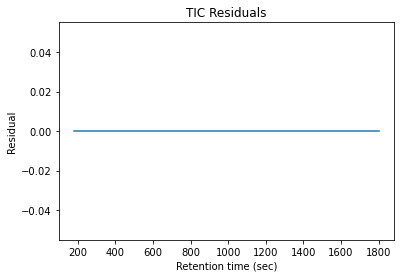

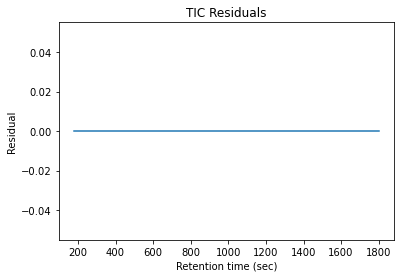

collecting peak data...


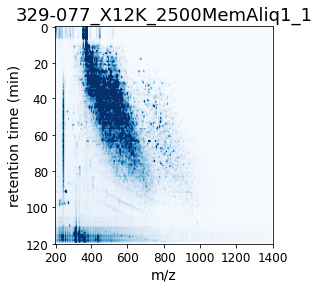

showing plot...
collecting peak data...


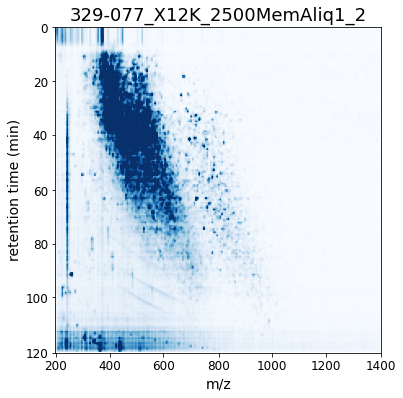

showing plot...
collecting peak data...


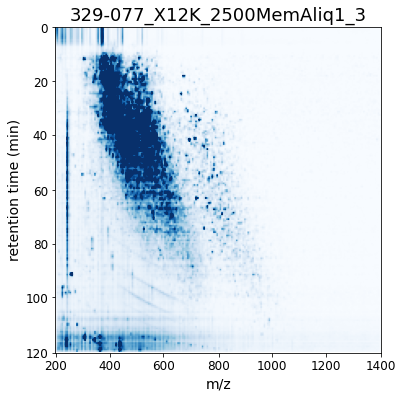

showing plot...
collecting peak data...


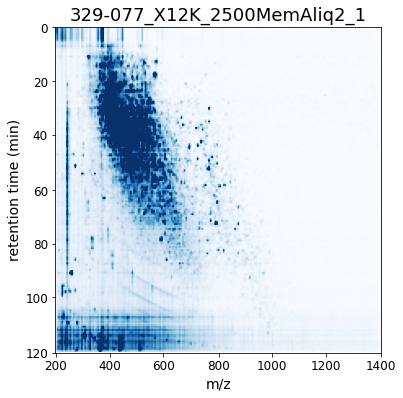

showing plot...
collecting peak data...


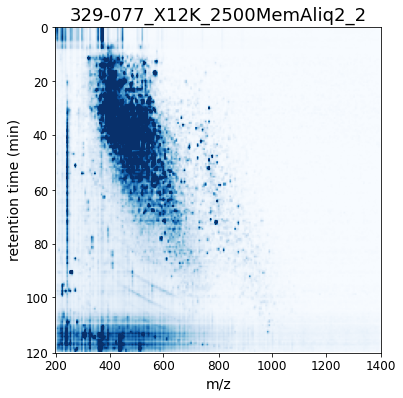

showing plot...
collecting peak data...


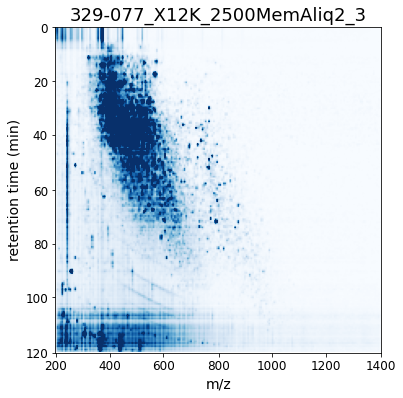

showing plot...
collecting peak data...


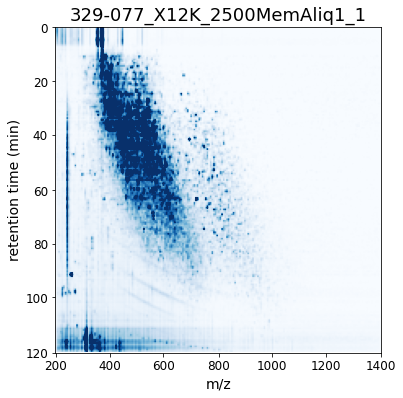

showing plot...
collecting peak data...


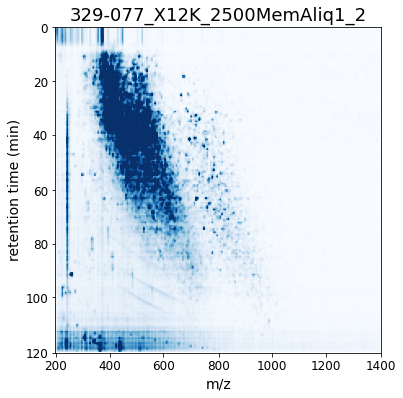

showing plot...
collecting peak data...


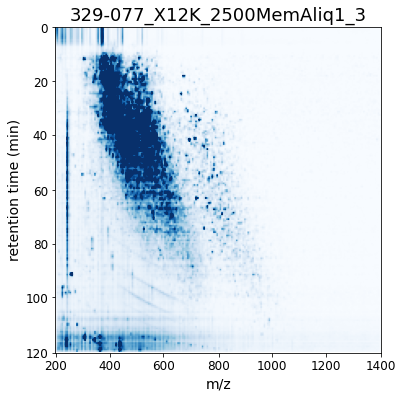

showing plot...
collecting peak data...


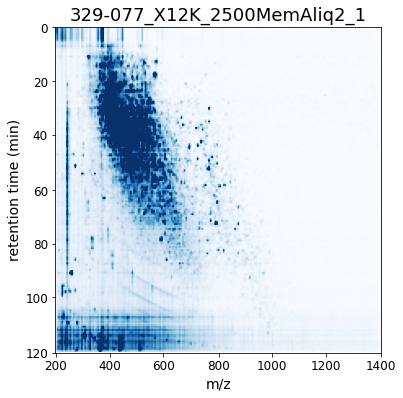

showing plot...
collecting peak data...


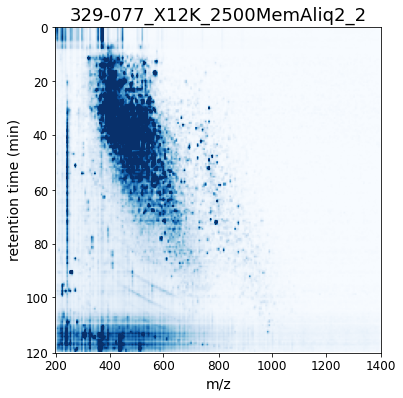

showing plot...
collecting peak data...


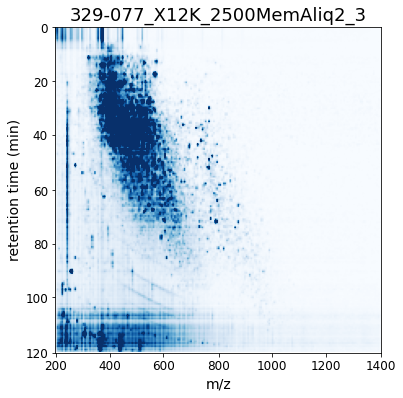

showing plot...


In [7]:
Methods.data_visualization(check_data,data_dir,png_dir,parent_dir)

## Feature Finding

In [8]:
column_names = []
feature_maps = []
files = []
files_full = []
# paper on feature finder: https://doi.org/10.1021/pr300992u

for file in sorted(os.listdir(data_dir)):
    if file.endswith('.mzML'):
        print(file)
        if not 'PRTC' in file:
            files.append(file[:-5])
            files_full.append(file)
        exp = MSExperiment()
        out = FeatureXMLFile()
        MzMLFile().load(os.path.join(data_dir,file),exp)
        exp.updateRanges()
        
        feature_finder = FeatureFinder()       
        # Get and set parameters 
        params = feature_finder.getParameters('centroided')
        params.setValue('mass_trace:mz_tolerance',0.004) # default 0.004, old opt 0.004
        params.setValue('isotopic_pattern:mz_tolerance',0.010) # default 0.005, old opt 0.010
        params.setValue('isotopic_pattern:charge_low',2)
        params.setValue('isotopic_pattern:charge_high',5)
        params.setValue('feature:max_rt_span',3.0) # default 2.5 - try 1.5,2,3 - done, old opt 3.0
        params.setValue('mass_trace:min_spectra',9) # default 10, try 9,8,7,6,5 - done, old opt 9 - 7 did nothing
        params.setValue('feature:rt_shape', 'asymmetric')  # default symmetric - done, old opt asymmetric
        params.setValue('seed:min_score',0.5)  # default 0.8, try 0.5,0.6,0.7 - done, old opt 0.5
        params.setValue('feature:min_score',0.5) # default 0.7, try 0.6, 0.5 - done, old opt 0.5
        params.setValue('mass_trace:max_missing',4)   # 1 is default, try 2,3,4,5 gave no features - done, old opt 4
        print(params.items())
    
        # Run feature finder and store as featureXML and in array
        if 'PRTC' in file:
            PRTC_feature_map = FeatureMap()
            feature_finder.run('centroided', exp, PRTC_feature_map, params, FeatureMap())
            PRTC_feature_map.setPrimaryMSRunPath([str.encode(file[:-5])])
            fXML = FeatureXMLFile()
            file_name = file[:-5] + '.featureXML'
            fXML.store(os.path.join(PRTC_dir,file_name),PRTC_feature_map)
        else:
            feature_map = FeatureMap()
            feature_finder.run('centroided', exp, feature_map, params, FeatureMap())
            feature_map.setPrimaryMSRunPath([str.encode(file[:-5])])
            feature_maps.append(feature_map)
            fXML = FeatureXMLFile()
            file_name = file[:-5] + '.featureXML'
            fXML.store(os.path.join(save_dir,file_name),feature_map)
        print('feature map done')
        print(' ')

329-077_X12K_2500MemAliq1_1.mzML
[(b'debug', 'false'), (b'intensity:bins', 10), (b'mass_trace:mz_tolerance', 0.004), (b'mass_trace:min_spectra', 9), (b'mass_trace:max_missing', 4), (b'mass_trace:slope_bound', 0.1), (b'isotopic_pattern:charge_low', 2), (b'isotopic_pattern:charge_high', 5), (b'isotopic_pattern:mz_tolerance', 0.01), (b'isotopic_pattern:intensity_percentage', 10.0), (b'isotopic_pattern:intensity_percentage_optional', 0.1), (b'isotopic_pattern:optional_fit_improvement', 2.0), (b'isotopic_pattern:mass_window_width', 25.0), (b'isotopic_pattern:abundance_12C', 98.93), (b'isotopic_pattern:abundance_14N', 99.632), (b'seed:min_score', 0.5), (b'fit:max_iterations', 500), (b'feature:min_score', 0.5), (b'feature:min_isotope_fit', 0.8), (b'feature:min_trace_score', 0.5), (b'feature:min_rt_span', 0.333), (b'feature:max_rt_span', 3.0), (b'feature:rt_shape', 'asymmetric'), (b'feature:max_intersection', 0.35), (b'feature:reported_mz', 'monoisotopic'), (b'user-seed:rt_tolerance', 5.0), (b

Found 22340 seeds for charge 2.
feature map done
 
329-077_X12K_2500MemAliq2_3.mzML
Found 2628 feature candidates for charge 2.
Found 18331 seeds for charge 3.
Found 2264 feature candidates for charge 3.
Found 13278 seeds for charge 4.
Found 1634 feature candidates for charge 4.
Found 1569 seeds for charge 5.
Found 146 feature candidates for charge 5.
Removed 1560 overlapping features.

Info: reasons for not finalizing a feature during its construction:
 - Could not extend seed: 18461 times
 - Could not find good enough isotope pattern containing the seed: 10563 times
 - Feature quality too low after fit: 11 times
 - Invalid feature after fit - too few traces or peaks left: 4834 times
 - Invalid fit: Center outside of feature bounds: 1358 times
 - Invalid fit: Fitted model is bigger than 'max_rt_span': 5124 times
 - Invalid fit: Less than 'min_rt_span' left after fit: 312 times

5112 features found.
Filename: '329-077_X12K_2500MemAliq2_2'
FeatureXMLFile::store():  found 6673 invalid un

## Feature alignment and grouping

In [9]:
# Use replicate with most features as reference
ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x: x[1])][-1]
ref_RTs = [f.getRT() for f in feature_maps[ref_index]]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner.setReference(feature_maps[ref_index])
align_params = aligner.getParameters()
align_params.setValue('superimposer:mz_pair_max_distance', 0.5) 
align_params.setValue('pairfinder:distance_RT:max_difference',300.00)
align_params.setValue('superimposer:max_shift',2000.0)
aligner.setParameters(align_params)

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index + 1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True)  # store original RT as meta value

new_RTs_list = []
original_RTs_dict = {}

for i,fm in enumerate(feature_maps):
    if i == ref_index:
        original_RTs_dict[i] = ref_RTs
    else:
        original_RT = [f.getMetaValue('original_RT') for f in fm]
        original_RTs_dict[i] = original_RT

alignment_dict = {}  # contains matrices of form [original_RT, aligned_RT]
for i,dic in enumerate(original_RTs_dict.values()):
    feature_map = feature_maps[i]
    RTs_array = []
    for j,RT_orig in enumerate(dic):
        pair = [RT_orig,feature_map[j].getRT()]
        RTs_array.append(pair)
    alignment_dict[i] = RTs_array

In [10]:
# Paper on feature grouper: https://doi.org/10.1021/pr300992u

feature_grouper = FeatureGroupingAlgorithmQT()  # Uses a quality threshold feature grouper
grouper_params = feature_grouper.getParameters()
grouper_params.setValue('distance_MZ:max_difference',0.01)
grouper_params.setValue('distance_RT:max_difference',150.0)
feature_grouper.setParameters(grouper_params)

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = feature_map.getMetaValue('spectra_data')[0].decode()
    file_description.size = feature_map.size()
    file_description.unique_id = feature_map.getUniqueId()
    file_descriptions[i] = file_description
    
consensus_map.setColumnHeaders(file_descriptions)
feature_grouper.group(feature_maps, consensus_map)

ConsensusXMLFile().store(os.path.join(save_dir,'consensusmap.consensusXML'),consensus_map)

Progress of 'Linking features':
-- done [took 0.30 s (CPU), 0.30 s (Wall)] -- 
ConsensusXMLFile::store():  found 17333 invalid unique ids


In [11]:
if PRTC_check:
    PRTC_features_mz = []
    PRTC_features_RT = []
#     for f in PRTC_feature_map:
#         obs_mass = (f.getMZ()*f.getCharge())-1.0074*f.getCharge()
#         if np.round(obs_mass,2) in PRTC_mass_round and f.getCharge() == 2:
#             PRTC_features_mz.append(f.getMZ())
#             PRTC_features_RT.append(f.getRT())

In [12]:
con_feat = []               
for cf in consensus_map:
    RT_cf = cf.getRT()
    Qual_cf = cf.getQuality()
    Charge_cf = cf.getCharge()
    MZ_cf = cf.getMZ()
    con_feat.append([cf.getRT(),cf.getCharge(),cf.getMZ(),cf.getQuality()])
    
map_idxs = []
map_RTs = []

for cf in consensus_map:
    map_idx = []
    map_RT = []
    for f in cf.getFeatureList():
        map_idx.append(f.getMapIndex())
        map_RT.append(f.getRT())
    map_idxs.append(map_idx)
    map_RTs.append(map_RT)

new_map_idxs = []
new_map_RTs = []   # these are the RTs from each feature map post-alignment

for i in range(len(map_RTs)):
    feat_idxs = map_idxs[i]
    feat_RTs = map_RTs[i]
    new_map_idx = []
    new_map_RT = []
    for i in range(len(feature_maps)):
        new_map_idx.append(i)
        if i in feat_idxs:
            RT = feat_RTs[feat_idxs.index(i)]
            new_map_RT.append(RT)
        if i not in feat_idxs:
            new_map_RT.append(0)   # this is where the problem is - if feature not in replicate, puts 0 for RT
    new_map_idxs.append(new_map_idx)
    new_map_RTs.append(new_map_RT)

### Alignment checks, original RT extraction

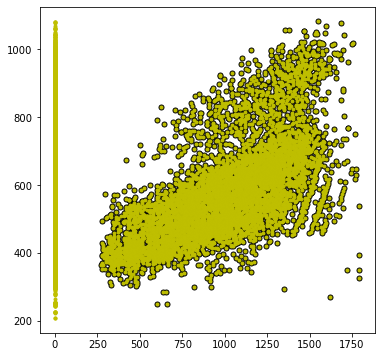

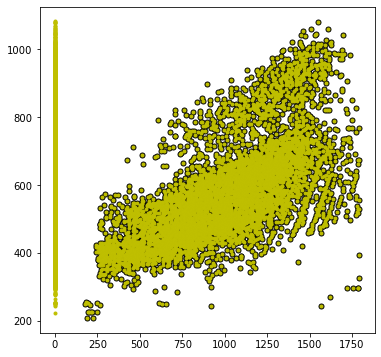

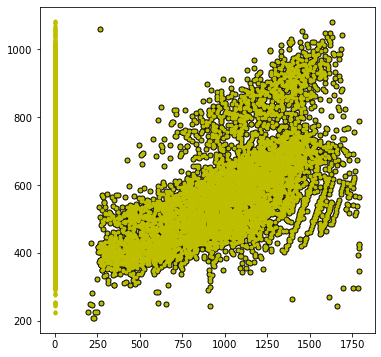

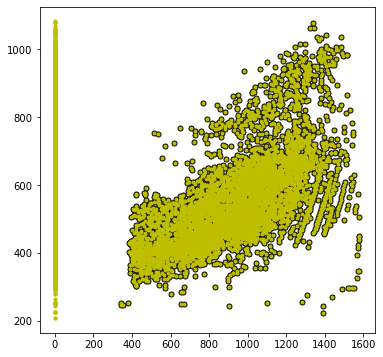

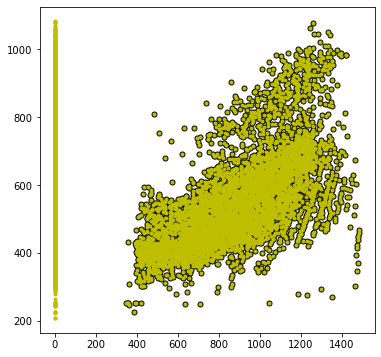

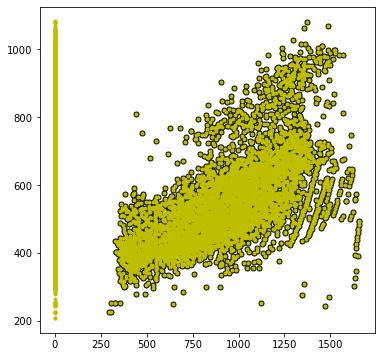

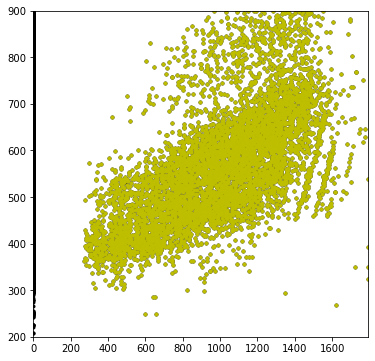

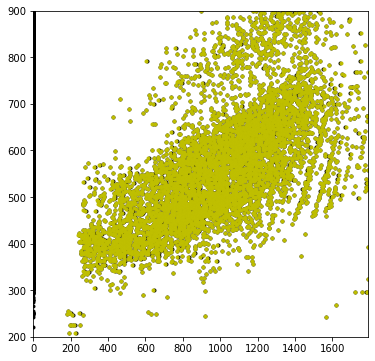

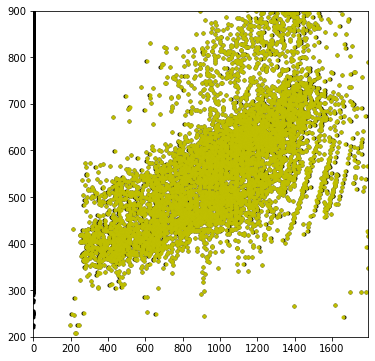

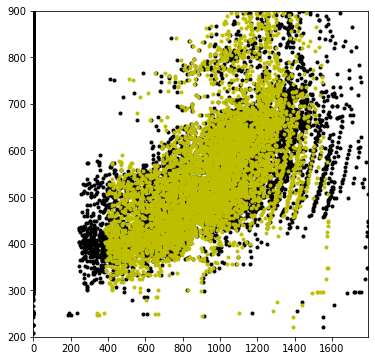

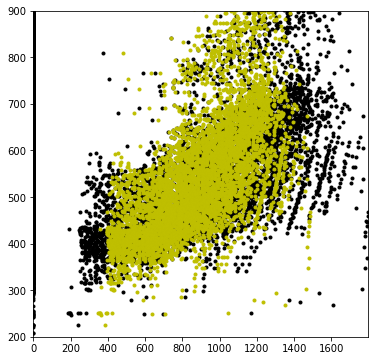

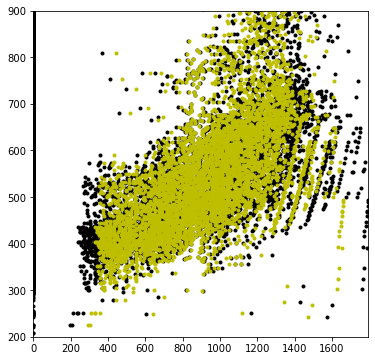

In [13]:
fixed_RT_maps_formatted = Methods.alignment_check(consensus_map,feature_maps,png_dir,new_map_RTs,files,original_RTs_dict)

In [14]:
col_names = []
for fm in feature_maps:
    col_names.append(fm.getMetaValue('spectra_data')[0].decode())

cf_df_1 = pd.DataFrame(con_feat,columns=['RT consensus','charge','m/z','quality'])
cf_df_3 = pd.DataFrame(fixed_RT_maps_formatted,columns=col_names)
cf_df_2 = pd.DataFrame(new_map_RTs,columns=col_names)

cf_df_final = pd.concat([cf_df_1,cf_df_2,cf_df_3],axis=1)
cf_df_final_np = cf_df_final.to_numpy()

cf_df_final.to_csv(os.path.join(parent_dir,folder,'Consensus Features.csv'),index=False)

feat_RT_cf_combined = []
feat_mz_combined = []
feat_z_combined = []
feat_quality_combined = []
feat_obs_mass_combined = []
RTs = []

for entry in cf_df_final_np:
    feat_RT_cf_combined.append(entry[0])
    feat_mz_combined.append(entry[2])
    feat_z_combined.append(entry[1])
    feat_obs_mass_combined.append(entry[2]*entry[1]-entry[1]*1.0074)
    feat_quality_combined.append(entry[3])
    RTs.append(entry[4:])
    
print(len(feat_mz_combined))
    
feat_RT_cf_combined_massfiltered = []
feat_RT_orig_massfiltered = []
feat_mz_combined_massfiltered = []
feat_z_combined_massfiltered = []
feat_quality_combined_massfiltered = []
feat_obs_mass_combined_massfiltered = []
RTs_massfiltered = []

ref_feature_mass = []
ref_feature_RT = []
ref_feature_RT_orig = []
refs_found = []

for i,obs_mass in enumerate(feat_obs_mass_combined):
    entry = cf_df_final_np[i]
    if PRTC_check and np.round(obs_mass,2) in PRTC_mass_round and entry[1] == 2:
        ref_feature_mass.append(entry[2])
        ref_feature_RT.append(entry[0])
        ref_feature_RT_orig.append(fixed_RT_maps_formatted[i])
        refs_found.append(np.round(obs_mass,2))
    elif obs_mass > 57.021*lib_size + 17.98 and obs_mass < 185.94*lib_size + 18.29:   # mass filter, all gly and all trp
        feat_RT_cf_combined_massfiltered.append(entry[0])
        feat_RT_orig_massfiltered.append(fixed_RT_maps_formatted[i])
        feat_mz_combined_massfiltered.append(entry[2])
        feat_z_combined_massfiltered.append(entry[1])
        feat_obs_mass_combined_massfiltered.append(entry[2]*entry[1]-entry[1]*1.0074)
        feat_quality_combined_massfiltered.append(entry[3])
        RTs_massfiltered.append(entry[4:])
    
if PRTC_check:
    for mass in PRTC_mass_round:
        if mass not in refs_found:
            warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
print(len(feat_mz_combined_massfiltered))

17332
16238


/state/partition1/slurm_tmp/20728998.0.0/ipykernel_550/963555180.py:63: UserWarning: Warning: PRTC reference mass 900.55 not found in consensus features!
  warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
/state/partition1/slurm_tmp/20728998.0.0/ipykernel_550/963555180.py:63: UserWarning: Warning: PRTC reference mass 985.52 not found in consensus features!
  warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
/state/partition1/slurm_tmp/20728998.0.0/ipykernel_550/963555180.py:63: UserWarning: Warning: PRTC reference mass 1114.64 not found in consensus features!
  warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
/state/partition1/slurm_tmp/20728998.0.0/ipykernel_550/963555180.py:63: UserWarning: Warning: PRTC reference mass 1171.59 not found in consensus features!
  warnings.warn(f"Warning: PRTC reference mass {mass} not found in consensus features!")
/state/partition1/slurm_tm

In [15]:
mzs_list,RTs_list,ints_list = Methods.get_data(data_dir)

329-077_X12K_2500MemAliq1_1
329-077_X12K_2500MemAliq1_2
329-077_X12K_2500MemAliq1_3
329-077_X12K_2500MemAliq2_1
329-077_X12K_2500MemAliq2_2
329-077_X12K_2500MemAliq2_3


In [16]:
### Get PRTC peptide areas from initial reference
if PRTC_check:
    mzs_ref,RTs_ref,ints_ref = Methods.get_data(PRTC_dir)
    _,rt_windows_start,int_windows_start,_ = Methods.feature_int_extractor_start(PRTC_features_mz,PRTC_features_RT,mzs_ref,RTs_ref,ints_ref,LOD=1.5E4,noise_level=1.5e4,peak_range=peak_RT)
    areas_PRTC = [val[0] for val in Methods.feature_area_extractor_savgol(rt_windows_start,int_windows_start)]

    PRTCs_found_start = np.unique(np.round(PRTC_features_mz,1))
    PRTC_area_ref = {}
    for mass in PRTCs_found_start:
        idxs = np.where(np.round(PRTC_features_mz,1) == mass)[0]
        area_ion = np.average([np.average(entry) for entry in [areas_PRTC[j] for j in idxs if areas_PRTC[j] > 1]])
        PRTC_area_ref[mass] = area_ion

In [17]:
if PRTC_check:
    ### Get PRTC peptide areas within replicates
    ints_ref,rt_windows_ref,int_windows_ref,backs_ref = Methods.feature_int_extractor(ref_feature_mass,ref_feature_RT,ref_feature_RT_orig,mzs_list,RTs_list,ints_list,LOD=1.5E4,noise_level=1.5e4,peak_range=peak_RT)
    areas_ref_full = Methods.feature_area_extractor_savgol(rt_windows_ref,int_windows_ref)
    areas_ref_average = [np.average(entry) for entry in areas_ref_full]
    area_ref = np.average(areas_ref_average)*conc_lib_start/PRTC_conc

0
0


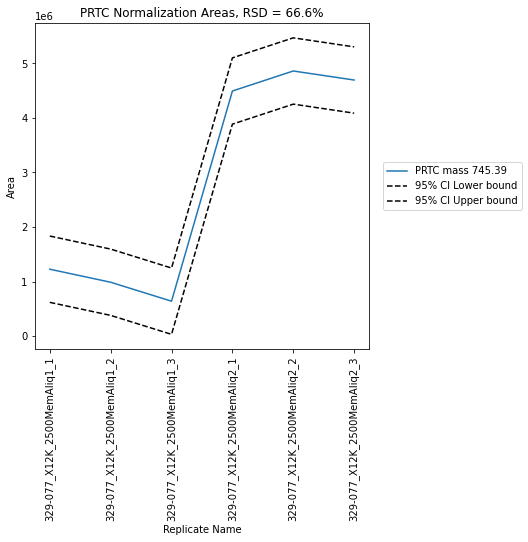

<Figure size 432x432 with 0 Axes>

In [18]:
if PRTC_check:
    Methods.PRTC_stats(areas_ref_full,files,ref_feature_mass,png_dir)

    PRTCs_found = np.unique(np.round(ref_feature_mass,1))
    PRTC_area_reps = {}
    for mass in PRTCs_found:
        idxs = np.where(np.round(ref_feature_mass,1) == mass)[0]
        area_average_ion = np.average([np.average(entry) for entry in [[area for area in areas_ref_full[j] if area > 1] for j in idxs]])
        PRTC_area_reps[mass] = area_average_ion

In [19]:
max_ints,rt_windows, int_windows, backgrounds = Methods.feature_int_extractor(feat_mz_combined_massfiltered,feat_RT_cf_combined_massfiltered,feat_RT_orig_massfiltered,mzs_list,RTs_list,ints_list,LOD=1.5E4,noise_level=1.5E4,peak_range=peak_RT)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [20]:
if use_savgol:
    peak_regular = Methods.peak_finder_savgol(rt_windows,int_windows,prots,plot=False,default_thresh=default_thresh,kernal_size=3,width=5,rel_height=0.5,reps=n_reps)
    peak_filtered = []
    feat_mz_filtered = []
    feat_RT_filtered = []
    feat_RT_orig_filtered = []
    feat_z_filtered = []
    check_rt_windows = []
    check_int_windows = []
    max_ints_filtered = []
    for i,peak_group in enumerate(peak_regular):
        test = np.concatenate(peak_group)
        if np.any(test):
            peak_filtered.append(peak_group)
            feat_mz_filtered.append(feat_mz_combined_massfiltered[i])
            feat_RT_filtered.append(feat_RT_cf_combined_massfiltered[i])
            feat_RT_orig_filtered.append(feat_RT_orig_massfiltered[i])
            check_rt_windows.append(rt_windows[i])
            check_int_windows.append(int_windows[i])
            feat_z_filtered.append(feat_z_combined_massfiltered[i])
            max_ints_filtered.append(max_ints[i])

    print(f'Features removed: {len(feat_mz_combined_massfiltered) - len(feat_mz_filtered)}')
    print(f'Features remaining: {len(feat_mz_filtered)}')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
Features removed: 8986
Features remaining: 7252


In [21]:
areas_savgol = Methods.feature_area_extractor_savgol(check_rt_windows,check_int_windows,check=False,width_start=10,prominence=2,threshold=10,rel_height=0.85)

0
1000
2000
3000
4000
5000
6000
7000


In [22]:
if not PRTC_check:
    area_ref = 1
    
enrichmentscores,enrichment_normalized,pvals,specifics,spec_label = Methods.enr_scoring(areas_savgol,area_ref,prots,prots,reps=n_reps,p_score_cutoff=p_score_cutoff)

Moving on to stats
Moving on to scoring


In [23]:
if not do_second_filter:
    feat_mz_filtered = feat_mz_combined_massfiltered
    feat_RT_filtered = feat_RT_cf_combined_massfiltered
    feat_z_filtered = feat_z_combined_massfiltered
    max_ints_filtered = max_ints

## Outputs

In [24]:
es_graphing,es_normalized_graphing,ps_graphing,RTs_graphing,RTs_graphing_orig,mzs_graphing,z_graphing,areas_graphing,es_nonspecific,es_normalized_nonspecific,ps_nonspecific,RTs_nonspecific,RTs_nonspecific_orig, \
    mzs_nonspecific,z_nonspecific,areas_nonspecific, es_unclear,es_normalized_unclear,ps_unclear,RTs_unclear,RTs_unclear_orig,mzs_unclear,z_unclear,areas_unclear = Methods.setup_output(prots,spec_label,enrichmentscores,enrichment_normalized,pvals,feat_RT_filtered,feat_RT_orig_filtered,feat_mz_filtered,feat_z_filtered,areas_savgol)

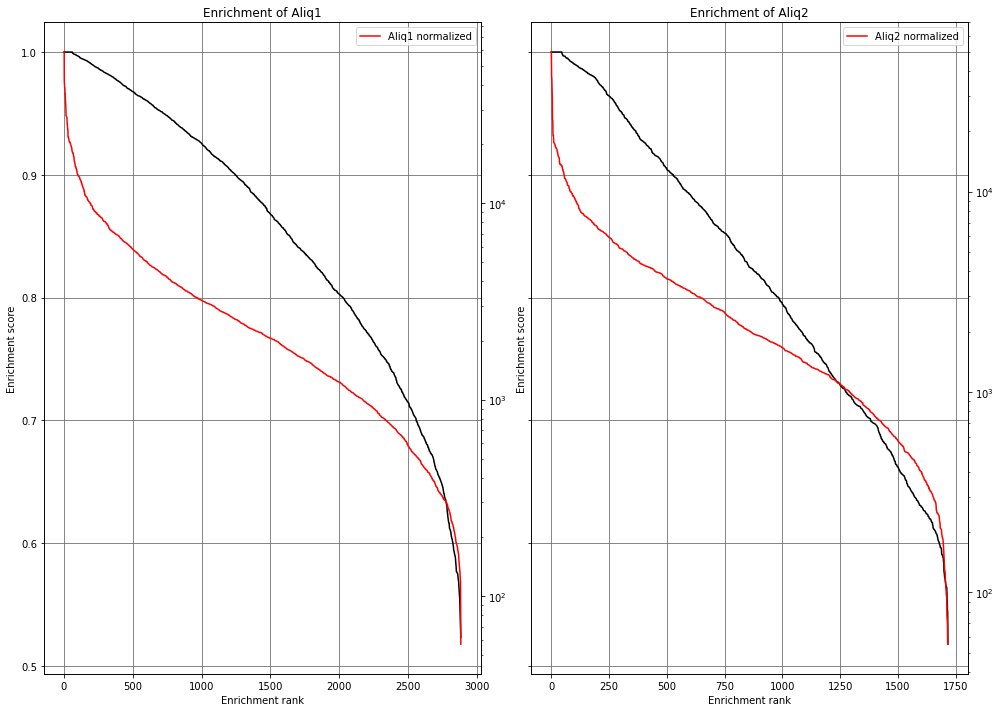

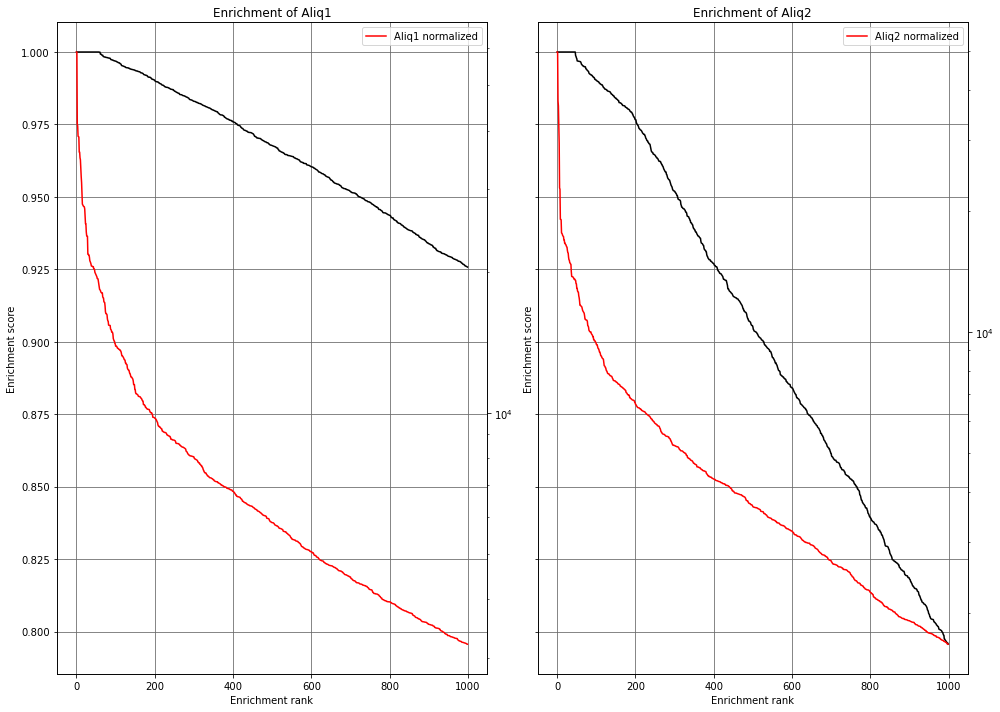

In [25]:
Methods.enrichment_rankings(prots,es_graphing,es_normalized_graphing,png_dir)

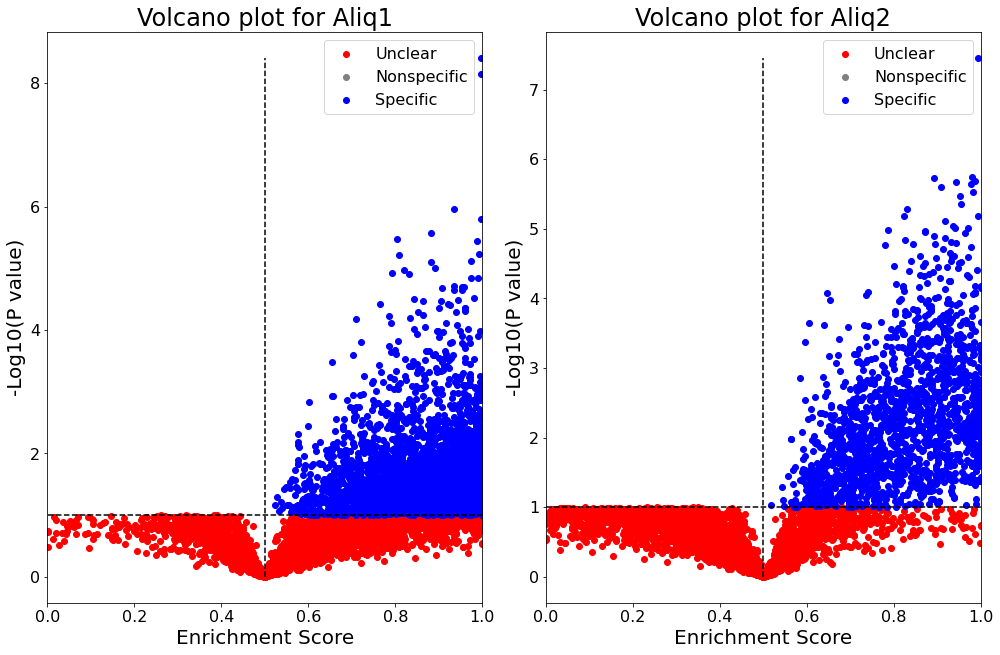

In [26]:
Methods.volcano_plotting(prots,es_graphing,es_nonspecific,es_unclear,ps_graphing,ps_nonspecific,ps_unclear,feat_mz_combined,enrichmentscores,p_score_cutoff,enr_score_cutoff,save_dir)

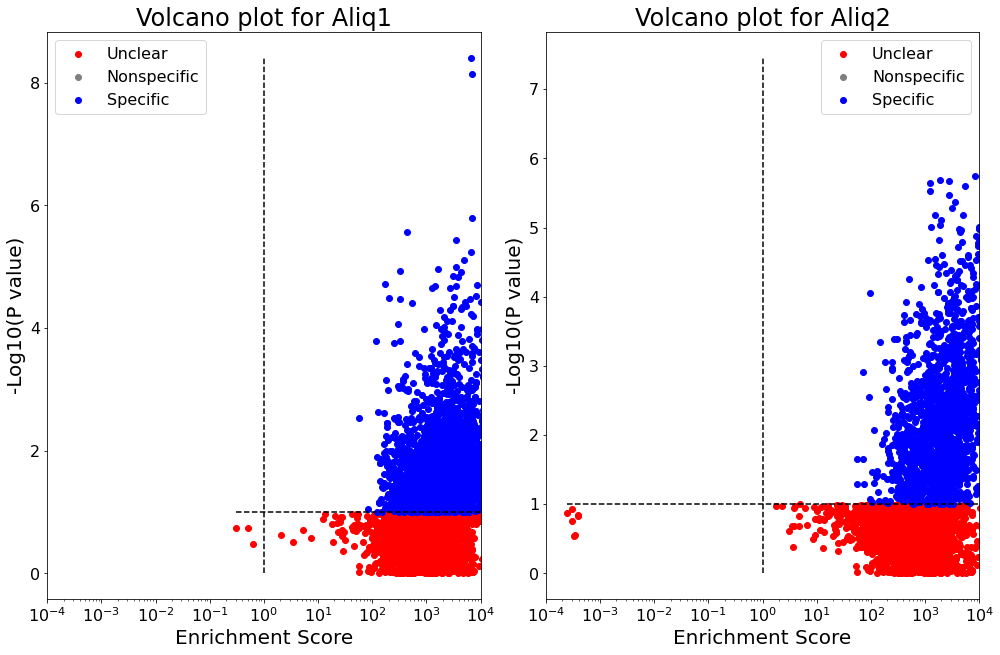

In [27]:
Methods.volcano_plots_normalized(prots,es_normalized_graphing,es_normalized_nonspecific,es_normalized_unclear,ps_graphing,ps_nonspecific,ps_unclear,p_score_cutoff,enr_score_cutoff,save_dir)

In [28]:
Methods.export_results(enrichmentscores,es_graphing,RTs_graphing,mzs_graphing,ps_graphing,z_graphing,enr_score_cutoff,
               p_score_cutoff,prots,parent_dir,folder,feat_RT_cf_combined,feat_mz_filtered,
               feat_z_filtered,pvals,spec_label,areas_savgol,full_out)

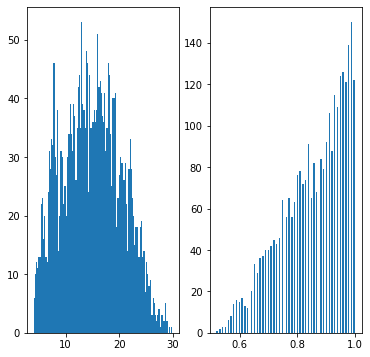

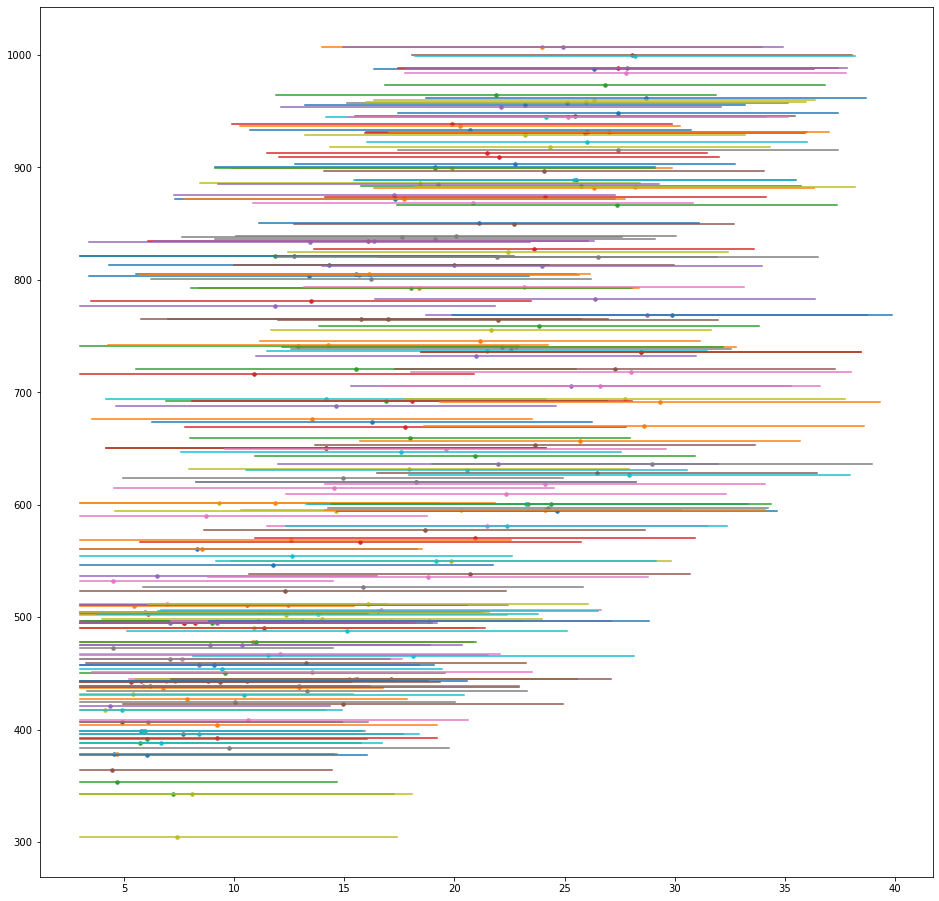

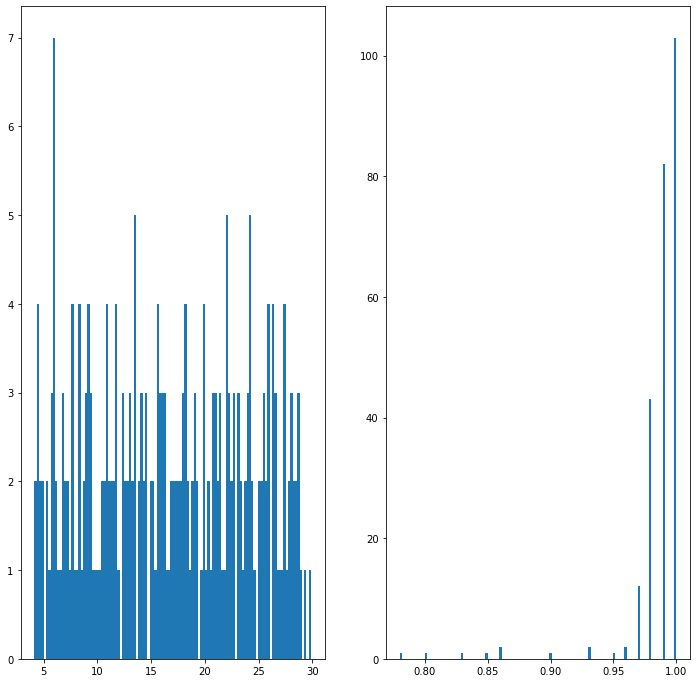

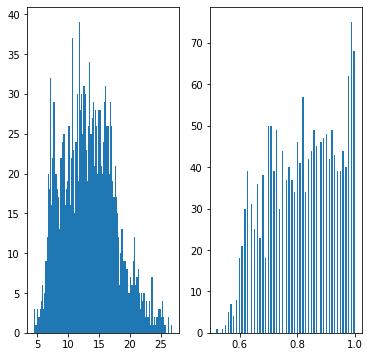

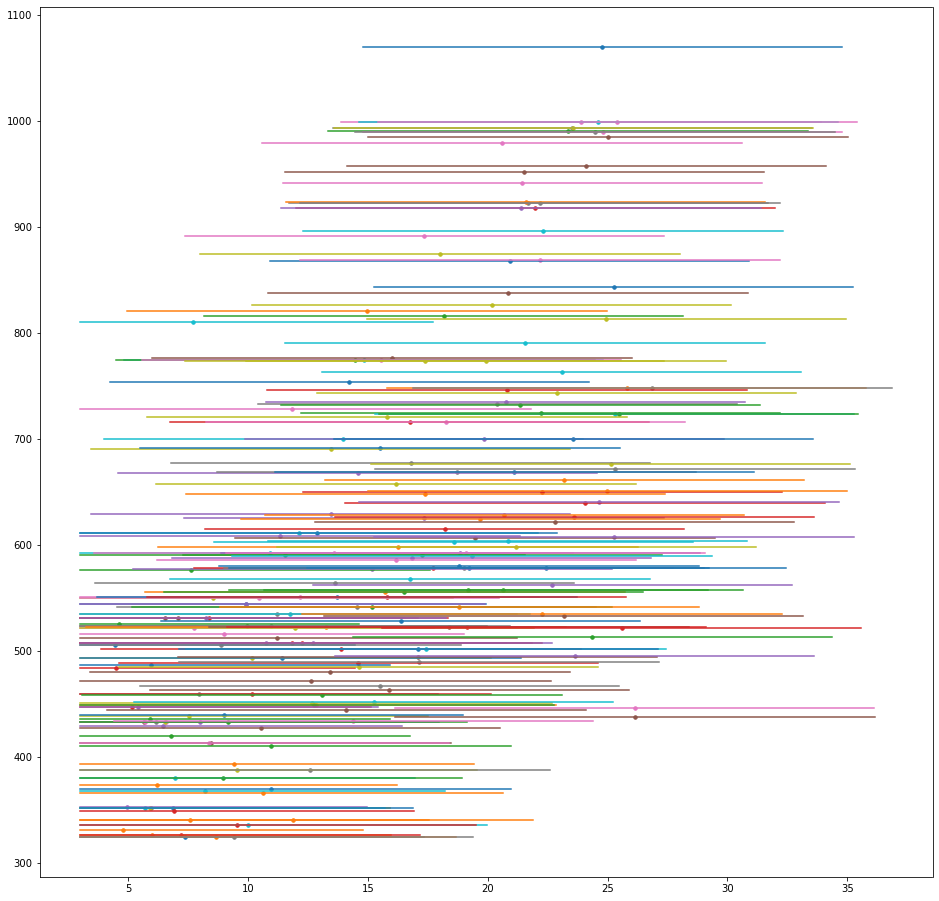

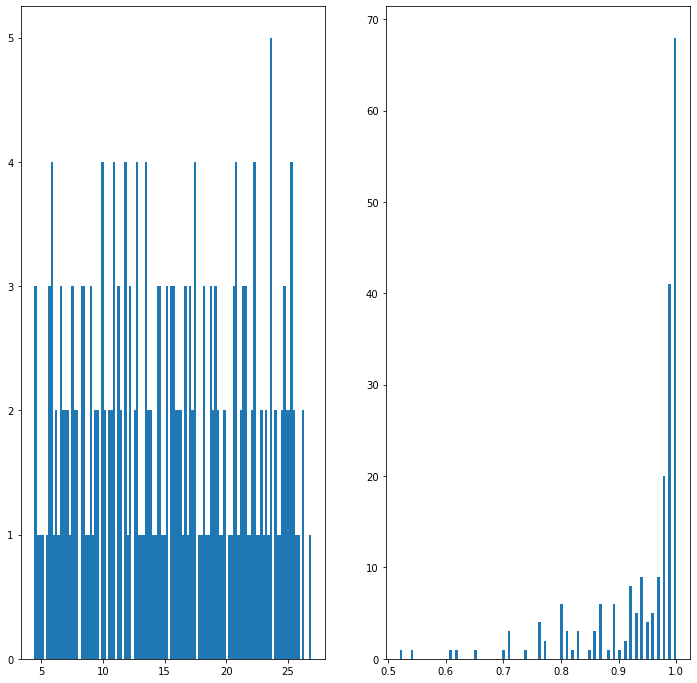

In [29]:
Methods.inclusion_lists(parent_dir,save_dir,png_dir,folder,prots,gradient_time,peps_min)

In [30]:
Methods.inclusion_areascorefiltered(es_graphing,RTs_graphing,RTs_graphing_orig,mzs_graphing,ps_graphing,z_graphing,areas_graphing,
                                enr_score_cutoff,p_score_cutoff,prots,parent_dir,folder,
                                n_reps,area_limit,min_escore_quality,gradient_time)

In [ ]:
Methods.inclusion_areascorefiltered_excel(parent_dir,folder,prots,num=1000)

329-077_X12K_2500MemAliq1_1.mzML
329-077_X12K_2500MemAliq1_2.mzML
329-077_X12K_2500MemAliq1_3.mzML
329-077_X12K_2500MemAliq2_1.mzML
329-077_X12K_2500MemAliq2_2.mzML
329-077_X12K_2500MemAliq2_3.mzML
Working on Aliq1
/home/gridsan/mlee/ASMS_Analysis/20221129-329-077_X12K_2500_Members_Targeted_Seq_Test/329-077 X12K Targeted Test Updated 2022_12_01-08_44_08_AM/EICs Excel/EICs of Aliq1.xlsx
Working on Aliq2
/home/gridsan/mlee/ASMS_Analysis/20221129-329-077_X12K_2500_Members_Targeted_Seq_Test/329-077 X12K Targeted Test Updated 2022_12_01-08_44_08_AM/EICs Excel/EICs of Aliq2.xlsx


In [ ]:
Methods.compare_known_binders(known_binders,prots,parent_dir,folder,feat_mz_combined_massfiltered,feat_mz_combined,feat_RT_cf_combined)

### EICs

In [28]:
# if do_EICs:
#     if PRTC_check:
#         plot_PRTC(ref_feature_mass,ref_feature_RT,ref_feature_RT_orig,areas_ref_full,data_dir,PRTC_dir,baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
    
#     for i,score in enumerate(es_graphing):
#         score_sorted = np.sort(score)[::-1]
#         indices_sorted = np.argsort(score)[::-1]
#         count = 0
#         mzs = []
#         RTs = []
#         RTs_orig = []
#         scores = []
#         p_to_graph = []
#         areas_to_graph = []
#         while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
#             index = indices_sorted[count]
#             mzs.append(mzs_graphing[i][index])
#             RTs.append(RTs_graphing[i][index])
#             RTs_orig.append(RTs_graphing_orig[i][index])
#             scores.append(score_sorted[count])
#             p_to_graph.append(ps_graphing[i][index][0])
#             areas_to_graph.append(areas_graphing[i][index])
#             count -= -1
#             if count >= len(score):
#                 break
#         print(' ')
#         specific = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_spec[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
#     if es_nonspecific:
#         for i in range(len(prots)):
#             score = [entry[i] for entry in es_nonspecific]
#             score_sorted = np.sort(score)[::-1]
#             indices_sorted = np.argsort(score)[::-1]
#             count = 0
#             mzs = []
#             RTs = []
#             RTs_orig = []
#             scores = []
#             p_to_graph = []
#             areas_to_graph = []
#             while score_sorted[count] >= enr_score_cutoff and len(scores) < nr_EICs:
#                 index = indices_sorted[count]
#                 mzs.append(mzs_nonspecific[index])
#                 RTs.append(RTs_nonspecific[index])
#                 RTs_orig.append(RTs_nonspecific_orig[index])
#                 scores.append(score_sorted[count])
#                 p_to_graph.append(ps_nonspecific[index][0])
#                 areas_to_graph.append(areas_nonspecific[index])
#                 count -= -1
#                 if count >= len(score):
#                     break
#             print(' ')
#             nonspecific = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_nonspec[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)
#     for i in range(len(prots)):
#         score = [entry[i] for entry in es_unclear]
#         score_sorted = np.sort(score)[::-1]
#         indices_sorted = np.argsort(score)[::-1]
#         count = 0
#         mzs = []
#         RTs = []
#         RTs_orig = []
#         scores = []
#         p_to_graph = []
#         areas_to_graph = []
#         while len(scores) < nr_EICs:
#             index = indices_sorted[count]
#             mzs.append(mzs_unclear[index])
#             RTs.append(RTs_unclear[index])
#             RTs_orig.append(RTs_unclear_orig[index])
#             scores.append(score_sorted[count])
#             p_to_graph.append(ps_unclear[index][0])
#             areas_to_graph.append(areas_unclear[index])
#             count -= -1
#             if count >= len(score):
#                 break
#         print(' ')
#         unclear = plot_EIC(mzs,RTs,RTs_orig,scores,p_to_graph,areas_to_graph,data_dir,eic_dirs_other[i],baseline=0,peak_range=peak_RT,show_plot=show_EICs,reps=n_reps)